In [23]:
# Data processing
# ==============================================================================
import numpy as np
import pandas as pd

# Plots
# ==============================================================================
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
import plotly.express as px
plt.style.use('fivethirtyeight')
plt.rcParams['lines.linewidth'] = 1.5
%matplotlib inline

# Modelling and Forecasting
# ==============================================================================
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline

from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.ForecasterAutoregMultiOutput import ForecasterAutoregMultiOutput
from skforecast.model_selection import grid_search_forecaster
from skforecast.model_selection import backtesting_forecaster

from joblib import dump, load

In [24]:
#Reading in data
# ==============================================================================
building4=pd.read_csv('Building 4.csv')

In [25]:
#Converting to Datetime objects
# ==============================================================================
building4['datetime']=pd.to_datetime(building4['datetime'], format='%Y-%m-%d %H:%M:%S')
building4= building4.set_index('datetime')
building4= building4.asfreq('H')

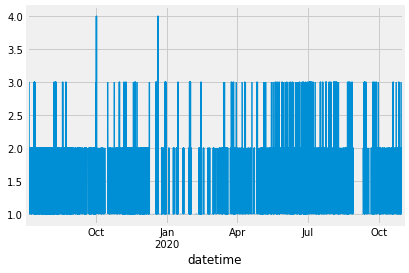

In [26]:
building4['series_value'].plot()

In [28]:
#Further Split Train-Val for Buildings
# ==============================================================================
end_train='2019-10-01 00:00'
start_val='2019-11-01 00:00'
end_val='2019-12-01 00:00'
start_test='2020-06-01 00:00'
end_test='2020-07-01 00:00'


building4train=building4.loc[:end_train, :]
building4val=building4.loc[start_val:end_val, :]
building4test=building4.loc[start_test: end_test, :]

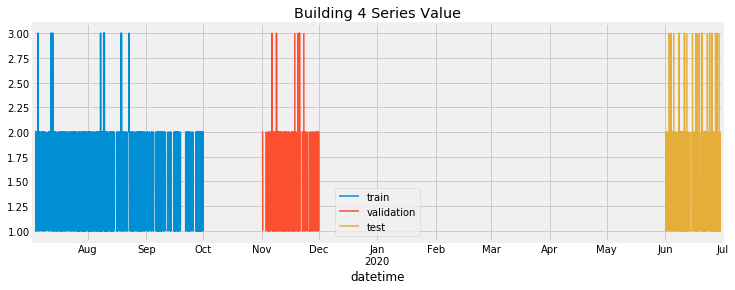

In [30]:
# Plot time series
# ==============================================================================
fig, ax = plt.subplots(figsize=(11, 4))
building4train['series_value'].plot(ax=ax, label='train')
building4val['series_value'].plot(ax=ax, label='validation')
building4test['series_value'].plot(ax=ax, label='test')
ax.set_title('Building 4 Series Value')
ax.legend();

In [31]:
building4=building4.dropna()

In [32]:
# Create LightGBM forecaster
# ==============================================================================
forecaster = ForecasterAutoreg(
                regressor = LGBMRegressor(random_state=123),
                lags = 24
                )

forecaster

ForecasterAutoreg 
Regressor: LGBMRegressor(random_state=123) 
Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24] 
Window size: 24 
Included exogenous: False 
Type of exogenous variable: None 
Exogenous variables names: None 
Training range: None 
Training index type: None 
Training index frequency: None 
Regressor parameters: {'boosting_type': 'gbdt', 'class_weight': None, 'colsample_bytree': 1.0, 'importance_type': 'split', 'learning_rate': 0.1, 'max_depth': -1, 'min_child_samples': 20, 'min_child_weight': 0.001, 'min_split_gain': 0.0, 'n_estimators': 100, 'n_jobs': -1, 'num_leaves': 31, 'objective': None, 'random_state': 123, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'silent': 'warn', 'subsample': 1.0, 'subsample_for_bin': 200000, 'subsample_freq': 0} 
Creation date: 2022-09-24 12:41:32 
Last fit date: None 
Skforecast version: 0.4.3 

In [34]:
# Grid search of hyperparameters and lags
# ==============================================================================
# Regressor hyperparameters

param_grid = {
    'n_estimators': [100, 500],
    'max_depth': [3, 5, 10],
    'learning_rate': [0.01, 0.1]
    }
lags_grid = [24, 48, 72, [1, 2, 3, 23, 24, 25, 71, 72, 73]]

results_grid = grid_search_forecaster(
                        forecaster         = forecaster,
                        y                  = building4.loc[:end_val, 'series_value'],
                        metric             = 'mean_squared_error',
                        initial_train_size = int(len(building4train)),
                        lags_grid          = lags_grid,
                        param_grid         = param_grid,
                        steps              = 36,
                        )

Number of models compared: 48


loop param_grid:   0%|                                             | 0/12 [00:00<?, ?it/s]C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:247: UserWarning: `y` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`y` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 2155
Number of observations used for backtesting: 398
    Number of folds: 12
    Number of steps per fold: 36
    Last fold only includes 2 observations

Data partition in fold: 0
    Training:   2019-07-03 06:00:00 -- 2019-11-08 08:00:00
    Validation: 2019-11-08 09:00:00 -- 2019-11-10 00:00:00
Data partition in fold: 1
    Training:   2019-07-03 06:00:00 -- 2019-11-08 08:00:00
    Validation: 2019-11-10 03:00:00 -- 2019-11-12 03:00:00
Data partition in fold: 2
    Training:   2019-07-03 06:00:00 -- 2019-11-08 08:00:00
    Validation: 2019-11-12 04:00:00 -- 2019-11-13 22:00:00
Data partition in fold: 3
    Training:   2019-07-03 06:00:00 -- 2019-11-08 08:00:00
    Validation: 2019-11-13 23:00:00 -- 2019-11-16 04:00:00
Data partition in fold: 4
    Training:   2019-07-03 06:00:00 -- 2019-11-08 08:00:00
    Validation: 2019-11-16 06:00:00 -- 2019

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:247: UserWarning: `y` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`y` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
 


----------------------------------
Number of observations used for initial training or as initial window: 2155
Number of observations used for backtesting: 398
    Number of folds: 12
    Number of steps per fold: 36
    Last fold only includes 2 observations

Data partition in fold: 0
    Training:   2019-07-03 06:00:00 -- 2019-11-08 08:00:00
    Validation: 2019-11-08 09:00:00 -- 2019-11-10 00:00:00
Data partition in fold: 1
    Training:   2019-07-03 06:00:00 -- 2019-11-08 08:00:00
    Validation: 2019-11-10 03:00:00 -- 2019-11-12 03:00:00
Data partition in fold: 2
    Training:   2019-07-03 06:00:00 -- 2019-11-08 08:00:00
    Validation: 2019-11-12 04:00:00 -- 2019-11-13 22:00:00
Data partition in fold: 3
    Training:   2019-07-03 06:00:00 -- 2019-11-08 08:00:00
    Validation: 2019-11-13 23:00:00 -- 2019-11-16 04:00:00
Data partition in fold: 4
    Training:   2019-07-03 06:00:00 -- 2019-11-08 08:00:00
    Validation: 2019-11-16 06:00:00 -- 2019-11-18 00:00:00
Data partition in 

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:247: UserWarning: `y` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`y` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
 

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 2155
Number of observations used for backtesting: 398
    Number of folds: 12
    Number of steps per fold: 36
    Last fold only includes 2 observations

Data partition in fold: 0
    Training:   2019-07-03 06:00:00 -- 2019-11-08 08:00:00
    Validation: 2019-11-08 09:00:00 -- 2019-11-10 00:00:00
Data partition in fold: 1
    Training:   2019-07-03 06:00:00 -- 2019-11-08 08:00:00
    Validation: 2019-11-10 03:00:00 -- 2019-11-12 03:00:00
Data partition in fold: 2
    Training:   2019-07-03 06:00:00 -- 2019-11-08 08:00:00
    Validation: 2019-11-12 04:00:00 -- 2019-11-13 22:00:00
Data partition in fold: 3
    Training:   2019-07-03 06:00:00 -- 2019-11-08 08:00:00
    Validation: 2019-11-13 23:00:00 -- 2019-11-16 04:00:00
Data partition in fold: 4
    Training:   2019-07-03 06:00:00 -- 2019-11-08 08:00:00
    Validation: 2019-11-16 06:00:00 -- 2019

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:247: UserWarning: `y` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`y` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
 

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 2155
Number of observations used for backtesting: 398
    Number of folds: 12
    Number of steps per fold: 36
    Last fold only includes 2 observations

Data partition in fold: 0
    Training:   2019-07-03 06:00:00 -- 2019-11-08 08:00:00
    Validation: 2019-11-08 09:00:00 -- 2019-11-10 00:00:00
Data partition in fold: 1
    Training:   2019-07-03 06:00:00 -- 2019-11-08 08:00:00
    Validation: 2019-11-10 03:00:00 -- 2019-11-12 03:00:00
Data partition in fold: 2
    Training:   2019-07-03 06:00:00 -- 2019-11-08 08:00:00
    Validation: 2019-11-12 04:00:00 -- 2019-11-13 22:00:00
Data partition in fold: 3
    Training:   2019-07-03 06:00:00 -- 2019-11-08 08:00:00
    Validation: 2019-11-13 23:00:00 -- 2019-11-16 04:00:00
Data partition in fold: 4
    Training:   2019-07-03 06:00:00 -- 2019-11-08 08:00:00
    Validation: 2019-11-16 06:00:00 -- 2019

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:247: UserWarning: `y` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`y` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
 

loop param_grid:  75%|███████████████████████████▊         | 9/12 [00:01<00:00,  6.06it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 2155
Number of observations used for backtesting: 398
    Number of folds: 12
    Number of steps per fold: 36
    Last fold only includes 2 observations

Data partition in fold: 0
    Training:   2019-07-03 06:00:00 -- 2019-11-08 08:00:00
    Validation: 2019-11-08 09:00:00 -- 2019-11-10 00:00:00
Data partition in fold: 1
    Training:   2019-07-03 06:00:00 -- 2019-11-08 08:00:00
    Validation: 2019-11-10 03:00:00 -- 2019-11-12 03:00:00
Data partition in fold: 2
    Training:   2019-07-03 06:00:00 -- 2019-11-08 08:00:00
    Validation: 2019-11-12 04:00:00 -- 2019-11-13 22:00:00
Data partition in fold: 3
    Training:   2019-07-03 06:00:00 -- 2019-11-08 08:00:00
    Validation: 2019-11-13 23:00:00 -- 2019-11-16 04:00:00
Data partition in fold: 4
    Training:   2019-07-03 06:00:00 -- 2019-11-08 08:00:00
    Validation: 2019-11-16 06:00:00 -- 2019

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:247: UserWarning: `y` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`y` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
 

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 2155
Number of observations used for backtesting: 398
    Number of folds: 12
    Number of steps per fold: 36
    Last fold only includes 2 observations

Data partition in fold: 0
    Training:   2019-07-03 06:00:00 -- 2019-11-08 08:00:00
    Validation: 2019-11-08 09:00:00 -- 2019-11-10 00:00:00
Data partition in fold: 1
    Training:   2019-07-03 06:00:00 -- 2019-11-08 08:00:00
    Validation: 2019-11-10 03:00:00 -- 2019-11-12 03:00:00
Data partition in fold: 2
    Training:   2019-07-03 06:00:00 -- 2019-11-08 08:00:00
    Validation: 2019-11-12 04:00:00 -- 2019-11-13 22:00:00
Data partition in fold: 3
    Training:   2019-07-03 06:00:00 -- 2019-11-08 08:00:00
    Validation: 2019-11-13 23:00:00 -- 2019-11-16 04:00:00
Data partition in fold: 4
    Training:   2019-07-03 06:00:00 -- 2019-11-08 08:00:00
    Validation: 2019-11-16 06:00:00 -- 2019

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:247: UserWarning: `y` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`y` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
 

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 2155
Number of observations used for backtesting: 398
    Number of folds: 12
    Number of steps per fold: 36
    Last fold only includes 2 observations

Data partition in fold: 0
    Training:   2019-07-03 06:00:00 -- 2019-11-08 08:00:00
    Validation: 2019-11-08 09:00:00 -- 2019-11-10 00:00:00
Data partition in fold: 1
    Training:   2019-07-03 06:00:00 -- 2019-11-08 08:00:00
    Validation: 2019-11-10 03:00:00 -- 2019-11-12 03:00:00
Data partition in fold: 2
    Training:   2019-07-03 06:00:00 -- 2019-11-08 08:00:00
    Validation: 2019-11-12 04:00:00 -- 2019-11-13 22:00:00
Data partition in fold: 3
    Training:   2019-07-03 06:00:00 -- 2019-11-08 08:00:00
    Validation: 2019-11-13 23:00:00 -- 2019-11-16 04:00:00
Data partition in fold: 4
    Training:   2019-07-03 06:00:00 -- 2019-11-08 08:00:00
    Validation: 2019-11-16 06:00:00 -- 2019


loop param_grid:   0%|                                             | 0/12 [00:00<?, ?it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 2155
Number of observations used for backtesting: 398
    Number of folds: 12
    Number of steps per fold: 36
    Last fold only includes 2 observations

Data partition in fold: 0
    Training:   2019-07-03 06:00:00 -- 2019-11-08 08:00:00
    Validation: 2019-11-08 09:00:00 -- 2019-11-10 00:00:00
Data partition in fold: 1
    Training:   2019-07-03 06:00:00 -- 2019-11-08 08:00:00
    Validation: 2019-11-10 03:00:00 -- 2019-11-12 03:00:00
Data partition in fold: 2
    Training:   2019-07-03 06:00:00 -- 2019-11-08 08:00:00
    Validation: 2019-11-12 04:00:00 -- 2019-11-13 22:00:00
Data partition in fold: 3
    Training:   2019-07-03 06:00:00 -- 2019-11-08 08:00:00
    Validation: 2019-11-13 23:00:00 -- 2019-11-16 04:00:00
Data partition in fold: 4
    Training:   2019-07-03 06:00:00 -- 2019-11-08 08:00:00
    Validation: 2019-11-16 06:00:00 -- 2019

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:247: UserWarning: `y` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`y` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
 

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 2155
Number of observations used for backtesting: 398
    Number of folds: 12
    Number of steps per fold: 36
    Last fold only includes 2 observations

Data partition in fold: 0
    Training:   2019-07-03 06:00:00 -- 2019-11-08 08:00:00
    Validation: 2019-11-08 09:00:00 -- 2019-11-10 00:00:00
Data partition in fold: 1
    Training:   2019-07-03 06:00:00 -- 2019-11-08 08:00:00
    Validation: 2019-11-10 03:00:00 -- 2019-11-12 03:00:00
Data partition in fold: 2
    Training:   2019-07-03 06:00:00 -- 2019-11-08 08:00:00
    Validation: 2019-11-12 04:00:00 -- 2019-11-13 22:00:00
Data partition in fold: 3
    Training:   2019-07-03 06:00:00 -- 2019-11-08 08:00:00
    Validation: 2019-11-13 23:00:00 -- 2019-11-16 04:00:00
Data partition in fold: 4
    Training:   2019-07-03 06:00:00 -- 2019-11-08 08:00:00
    Validation: 2019-11-16 06:00:00 -- 2019

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:247: UserWarning: `y` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`y` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
 

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 2155
Number of observations used for backtesting: 398
    Number of folds: 12
    Number of steps per fold: 36
    Last fold only includes 2 observations

Data partition in fold: 0
    Training:   2019-07-03 06:00:00 -- 2019-11-08 08:00:00
    Validation: 2019-11-08 09:00:00 -- 2019-11-10 00:00:00
Data partition in fold: 1
    Training:   2019-07-03 06:00:00 -- 2019-11-08 08:00:00
    Validation: 2019-11-10 03:00:00 -- 2019-11-12 03:00:00
Data partition in fold: 2
    Training:   2019-07-03 06:00:00 -- 2019-11-08 08:00:00
    Validation: 2019-11-12 04:00:00 -- 2019-11-13 22:00:00
Data partition in fold: 3
    Training:   2019-07-03 06:00:00 -- 2019-11-08 08:00:00
    Validation: 2019-11-13 23:00:00 -- 2019-11-16 04:00:00
Data partition in fold: 4
    Training:   2019-07-03 06:00:00 -- 2019-11-08 08:00:00
    Validation: 2019-11-16 06:00:00 -- 2019

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 2155
Number of observations used for backtesting: 398
    Number of folds: 12
    Number of steps per fold: 36
    Last fold only includes 2 observations

Data partition in fold: 0
    Training:   2019-07-03 06:00:00 -- 2019-11-08 08:00:00
    Validation: 2019-11-08 09:00:00 -- 2019-11-10 00:00:00
Data partition in fold: 1
    Training:   2019-07-03 06:00:00 -- 2019-11-08 08:00:00
    Validation: 2019-11-10 03:00:00 -- 2019-11-12 03:00:00
Data partition in fold: 2
    Training:   2019-07-03 06:00:00 -- 2019-11-08 08:00:00
    Validation: 2019-11-12 04:00:00 -- 2019-11-13 22:00:00
Data partition in fold: 3
    Training:   2019-07-03 06:00:00 -- 2019-11-08 08:00:00
    Validation: 2019-11-13 23:00:00 -- 2019-11-16 04:00:00
Data partition in fold: 4
    Training:   2019-07-03 06:00:00 -- 2019-11-08 08:00:00
    Validation: 2019-11-16 06:00:00 -- 2019

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:247: UserWarning: `y` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`y` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
 

loop param_grid:  58%|█████████████████████▌               | 7/12 [00:01<00:01,  4.59it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 2155
Number of observations used for backtesting: 398
    Number of folds: 12
    Number of steps per fold: 36
    Last fold only includes 2 observations

Data partition in fold: 0
    Training:   2019-07-03 06:00:00 -- 2019-11-08 08:00:00
    Validation: 2019-11-08 09:00:00 -- 2019-11-10 00:00:00
Data partition in fold: 1
    Training:   2019-07-03 06:00:00 -- 2019-11-08 08:00:00
    Validation: 2019-11-10 03:00:00 -- 2019-11-12 03:00:00
Data partition in fold: 2
    Training:   2019-07-03 06:00:00 -- 2019-11-08 08:00:00
    Validation: 2019-11-12 04:00:00 -- 2019-11-13 22:00:00
Data partition in fold: 3
    Training:   2019-07-03 06:00:00 -- 2019-11-08 08:00:00
    Validation: 2019-11-13 23:00:00 -- 2019-11-16 04:00:00
Data partition in fold: 4
    Training:   2019-07-03 06:00:00 -- 2019-11-08 08:00:00
    Validation: 2019-11-16 06:00:00 -- 2019

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:247: UserWarning: `y` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`y` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
 

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 2155
Number of observations used for backtesting: 398
    Number of folds: 12
    Number of steps per fold: 36
    Last fold only includes 2 observations

Data partition in fold: 0
    Training:   2019-07-03 06:00:00 -- 2019-11-08 08:00:00
    Validation: 2019-11-08 09:00:00 -- 2019-11-10 00:00:00
Data partition in fold: 1
    Training:   2019-07-03 06:00:00 -- 2019-11-08 08:00:00
    Validation: 2019-11-10 03:00:00 -- 2019-11-12 03:00:00
Data partition in fold: 2
    Training:   2019-07-03 06:00:00 -- 2019-11-08 08:00:00
    Validation: 2019-11-12 04:00:00 -- 2019-11-13 22:00:00
Data partition in fold: 3
    Training:   2019-07-03 06:00:00 -- 2019-11-08 08:00:00
    Validation: 2019-11-13 23:00:00 -- 2019-11-16 04:00:00
Data partition in fold: 4
    Training:   2019-07-03 06:00:00 -- 2019-11-08 08:00:00
    Validation: 2019-11-16 06:00:00 -- 2019

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 2155
Number of observations used for backtesting: 398
    Number of folds: 12
    Number of steps per fold: 36
    Last fold only includes 2 observations

Data partition in fold: 0
    Training:   2019-07-03 06:00:00 -- 2019-11-08 08:00:00
    Validation: 2019-11-08 09:00:00 -- 2019-11-10 00:00:00
Data partition in fold: 1
    Training:   2019-07-03 06:00:00 -- 2019-11-08 08:00:00
    Validation: 2019-11-10 03:00:00 -- 2019-11-12 03:00:00
Data partition in fold: 2
    Training:   2019-07-03 06:00:00 -- 2019-11-08 08:00:00
    Validation: 2019-11-12 04:00:00 -- 2019-11-13 22:00:00
Data partition in fold: 3
    Training:   2019-07-03 06:00:00 -- 2019-11-08 08:00:00
    Validation: 2019-11-13 23:00:00 -- 2019-11-16 04:00:00
Data partition in fold: 4
    Training:   2019-07-03 06:00:00 -- 2019-11-08 08:00:00
    Validation: 2019-11-16 06:00:00 -- 2019

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:247: UserWarning: `y` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`y` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
 

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 2155
Number of observations used for backtesting: 398
    Number of folds: 12
    Number of steps per fold: 36
    Last fold only includes 2 observations

Data partition in fold: 0
    Training:   2019-07-03 06:00:00 -- 2019-11-08 08:00:00
    Validation: 2019-11-08 09:00:00 -- 2019-11-10 00:00:00
Data partition in fold: 1
    Training:   2019-07-03 06:00:00 -- 2019-11-08 08:00:00
    Validation: 2019-11-10 03:00:00 -- 2019-11-12 03:00:00
Data partition in fold: 2
    Training:   2019-07-03 06:00:00 -- 2019-11-08 08:00:00
    Validation: 2019-11-12 04:00:00 -- 2019-11-13 22:00:00
Data partition in fold: 3
    Training:   2019-07-03 06:00:00 -- 2019-11-08 08:00:00
    Validation: 2019-11-13 23:00:00 -- 2019-11-16 04:00:00
Data partition in fold: 4
    Training:   2019-07-03 06:00:00 -- 2019-11-08 08:00:00
    Validation: 2019-11-16 06:00:00 -- 2019


loop param_grid:   0%|                                             | 0/12 [00:00<?, ?it/s]C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:247: UserWarning: `y` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`y` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` ha

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 2155
Number of observations used for backtesting: 398
    Number of folds: 12
    Number of steps per fold: 36
    Last fold only includes 2 observations

Data partition in fold: 0
    Training:   2019-07-03 06:00:00 -- 2019-11-08 08:00:00
    Validation: 2019-11-08 09:00:00 -- 2019-11-10 00:00:00
Data partition in fold: 1
    Training:   2019-07-03 06:00:00 -- 2019-11-08 08:00:00
    Validation: 2019-11-10 03:00:00 -- 2019-11-12 03:00:00
Data partition in fold: 2
    Training:   2019-07-03 06:00:00 -- 2019-11-08 08:00:00
    Validation: 2019-11-12 04:00:00 -- 2019-11-13 22:00:00
Data partition in fold: 3
    Training:   2019-07-03 06:00:00 -- 2019-11-08 08:00:00
    Validation: 2019-11-13 23:00:00 -- 2019-11-16 04:00:00
Data partition in fold: 4
    Training:   2019-07-03 06:00:00 -- 2019-11-08 08:00:00
    Validation: 2019-11-16 06:00:00 -- 2019

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 2155
Number of observations used for backtesting: 398
    Number of folds: 12
    Number of steps per fold: 36
    Last fold only includes 2 observations

Data partition in fold: 0
    Training:   2019-07-03 06:00:00 -- 2019-11-08 08:00:00
    Validation: 2019-11-08 09:00:00 -- 2019-11-10 00:00:00
Data partition in fold: 1
    Training:   2019-07-03 06:00:00 -- 2019-11-08 08:00:00
    Validation: 2019-11-10 03:00:00 -- 2019-11-12 03:00:00
Data partition in fold: 2
    Training:   2019-07-03 06:00:00 -- 2019-11-08 08:00:00
    Validation: 2019-11-12 04:00:00 -- 2019-11-13 22:00:00
Data partition in fold: 3
    Training:   2019-07-03 06:00:00 -- 2019-11-08 08:00:00
    Validation: 2019-11-13 23:00:00 -- 2019-11-16 04:00:00
Data partition in fold: 4
    Training:   2019-07-03 06:00:00 -- 2019-11-08 08:00:00
    Validation: 2019-11-16 06:00:00 -- 2019

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:247: UserWarning: `y` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`y` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
 

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 2155
Number of observations used for backtesting: 398
    Number of folds: 12
    Number of steps per fold: 36
    Last fold only includes 2 observations

Data partition in fold: 0
    Training:   2019-07-03 06:00:00 -- 2019-11-08 08:00:00
    Validation: 2019-11-08 09:00:00 -- 2019-11-10 00:00:00
Data partition in fold: 1
    Training:   2019-07-03 06:00:00 -- 2019-11-08 08:00:00
    Validation: 2019-11-10 03:00:00 -- 2019-11-12 03:00:00
Data partition in fold: 2
    Training:   2019-07-03 06:00:00 -- 2019-11-08 08:00:00
    Validation: 2019-11-12 04:00:00 -- 2019-11-13 22:00:00
Data partition in fold: 3
    Training:   2019-07-03 06:00:00 -- 2019-11-08 08:00:00
    Validation: 2019-11-13 23:00:00 -- 2019-11-16 04:00:00
Data partition in fold: 4
    Training:   2019-07-03 06:00:00 -- 2019-11-08 08:00:00
    Validation: 2019-11-16 06:00:00 -- 2019

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:247: UserWarning: `y` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`y` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
 

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 2155
Number of observations used for backtesting: 398
    Number of folds: 12
    Number of steps per fold: 36
    Last fold only includes 2 observations

Data partition in fold: 0
    Training:   2019-07-03 06:00:00 -- 2019-11-08 08:00:00
    Validation: 2019-11-08 09:00:00 -- 2019-11-10 00:00:00
Data partition in fold: 1
    Training:   2019-07-03 06:00:00 -- 2019-11-08 08:00:00
    Validation: 2019-11-10 03:00:00 -- 2019-11-12 03:00:00
Data partition in fold: 2
    Training:   2019-07-03 06:00:00 -- 2019-11-08 08:00:00
    Validation: 2019-11-12 04:00:00 -- 2019-11-13 22:00:00
Data partition in fold: 3
    Training:   2019-07-03 06:00:00 -- 2019-11-08 08:00:00
    Validation: 2019-11-13 23:00:00 -- 2019-11-16 04:00:00
Data partition in fold: 4
    Training:   2019-07-03 06:00:00 -- 2019-11-08 08:00:00
    Validation: 2019-11-16 06:00:00 -- 2019

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:247: UserWarning: `y` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`y` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
 

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 2155
Number of observations used for backtesting: 398
    Number of folds: 12
    Number of steps per fold: 36
    Last fold only includes 2 observations

Data partition in fold: 0
    Training:   2019-07-03 06:00:00 -- 2019-11-08 08:00:00
    Validation: 2019-11-08 09:00:00 -- 2019-11-10 00:00:00
Data partition in fold: 1
    Training:   2019-07-03 06:00:00 -- 2019-11-08 08:00:00
    Validation: 2019-11-10 03:00:00 -- 2019-11-12 03:00:00
Data partition in fold: 2
    Training:   2019-07-03 06:00:00 -- 2019-11-08 08:00:00
    Validation: 2019-11-12 04:00:00 -- 2019-11-13 22:00:00
Data partition in fold: 3
    Training:   2019-07-03 06:00:00 -- 2019-11-08 08:00:00
    Validation: 2019-11-13 23:00:00 -- 2019-11-16 04:00:00
Data partition in fold: 4
    Training:   2019-07-03 06:00:00 -- 2019-11-08 08:00:00
    Validation: 2019-11-16 06:00:00 -- 2019

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:247: UserWarning: `y` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`y` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
 

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 2155
Number of observations used for backtesting: 398
    Number of folds: 12
    Number of steps per fold: 36
    Last fold only includes 2 observations

Data partition in fold: 0
    Training:   2019-07-03 06:00:00 -- 2019-11-08 08:00:00
    Validation: 2019-11-08 09:00:00 -- 2019-11-10 00:00:00
Data partition in fold: 1
    Training:   2019-07-03 06:00:00 -- 2019-11-08 08:00:00
    Validation: 2019-11-10 03:00:00 -- 2019-11-12 03:00:00
Data partition in fold: 2
    Training:   2019-07-03 06:00:00 -- 2019-11-08 08:00:00
    Validation: 2019-11-12 04:00:00 -- 2019-11-13 22:00:00
Data partition in fold: 3
    Training:   2019-07-03 06:00:00 -- 2019-11-08 08:00:00
    Validation: 2019-11-13 23:00:00 -- 2019-11-16 04:00:00
Data partition in fold: 4
    Training:   2019-07-03 06:00:00 -- 2019-11-08 08:00:00
    Validation: 2019-11-16 06:00:00 -- 2019

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 2155
Number of observations used for backtesting: 398
    Number of folds: 12
    Number of steps per fold: 36
    Last fold only includes 2 observations

Data partition in fold: 0
    Training:   2019-07-03 06:00:00 -- 2019-11-08 08:00:00
    Validation: 2019-11-08 09:00:00 -- 2019-11-10 00:00:00
Data partition in fold: 1
    Training:   2019-07-03 06:00:00 -- 2019-11-08 08:00:00
    Validation: 2019-11-10 03:00:00 -- 2019-11-12 03:00:00
Data partition in fold: 2
    Training:   2019-07-03 06:00:00 -- 2019-11-08 08:00:00
    Validation: 2019-11-12 04:00:00 -- 2019-11-13 22:00:00
Data partition in fold: 3
    Training:   2019-07-03 06:00:00 -- 2019-11-08 08:00:00
    Validation: 2019-11-13 23:00:00 -- 2019-11-16 04:00:00
Data partition in fold: 4
    Training:   2019-07-03 06:00:00 -- 2019-11-08 08:00:00
    Validation: 2019-11-16 06:00:00 -- 2019

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:247: UserWarning: `y` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`y` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
 

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 2155
Number of observations used for backtesting: 398
    Number of folds: 12
    Number of steps per fold: 36
    Last fold only includes 2 observations

Data partition in fold: 0
    Training:   2019-07-03 06:00:00 -- 2019-11-08 08:00:00
    Validation: 2019-11-08 09:00:00 -- 2019-11-10 00:00:00
Data partition in fold: 1
    Training:   2019-07-03 06:00:00 -- 2019-11-08 08:00:00
    Validation: 2019-11-10 03:00:00 -- 2019-11-12 03:00:00
Data partition in fold: 2
    Training:   2019-07-03 06:00:00 -- 2019-11-08 08:00:00
    Validation: 2019-11-12 04:00:00 -- 2019-11-13 22:00:00
Data partition in fold: 3
    Training:   2019-07-03 06:00:00 -- 2019-11-08 08:00:00
    Validation: 2019-11-13 23:00:00 -- 2019-11-16 04:00:00
Data partition in fold: 4
    Training:   2019-07-03 06:00:00 -- 2019-11-08 08:00:00
    Validation: 2019-11-16 06:00:00 -- 2019

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:247: UserWarning: `y` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`y` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
 

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 2155
Number of observations used for backtesting: 398
    Number of folds: 12
    Number of steps per fold: 36
    Last fold only includes 2 observations

Data partition in fold: 0
    Training:   2019-07-03 06:00:00 -- 2019-11-08 08:00:00
    Validation: 2019-11-08 09:00:00 -- 2019-11-10 00:00:00
Data partition in fold: 1
    Training:   2019-07-03 06:00:00 -- 2019-11-08 08:00:00
    Validation: 2019-11-10 03:00:00 -- 2019-11-12 03:00:00
Data partition in fold: 2
    Training:   2019-07-03 06:00:00 -- 2019-11-08 08:00:00
    Validation: 2019-11-12 04:00:00 -- 2019-11-13 22:00:00
Data partition in fold: 3
    Training:   2019-07-03 06:00:00 -- 2019-11-08 08:00:00
    Validation: 2019-11-13 23:00:00 -- 2019-11-16 04:00:00
Data partition in fold: 4
    Training:   2019-07-03 06:00:00 -- 2019-11-08 08:00:00
    Validation: 2019-11-16 06:00:00 -- 2019

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:247: UserWarning: `y` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`y` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
 

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 2155
Number of observations used for backtesting: 398
    Number of folds: 12
    Number of steps per fold: 36
    Last fold only includes 2 observations

Data partition in fold: 0
    Training:   2019-07-03 06:00:00 -- 2019-11-08 08:00:00
    Validation: 2019-11-08 09:00:00 -- 2019-11-10 00:00:00
Data partition in fold: 1
    Training:   2019-07-03 06:00:00 -- 2019-11-08 08:00:00
    Validation: 2019-11-10 03:00:00 -- 2019-11-12 03:00:00
Data partition in fold: 2
    Training:   2019-07-03 06:00:00 -- 2019-11-08 08:00:00
    Validation: 2019-11-12 04:00:00 -- 2019-11-13 22:00:00
Data partition in fold: 3
    Training:   2019-07-03 06:00:00 -- 2019-11-08 08:00:00
    Validation: 2019-11-13 23:00:00 -- 2019-11-16 04:00:00
Data partition in fold: 4
    Training:   2019-07-03 06:00:00 -- 2019-11-08 08:00:00
    Validation: 2019-11-16 06:00:00 -- 2019

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:247: UserWarning: `y` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`y` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
 

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 2155
Number of observations used for backtesting: 398
    Number of folds: 12
    Number of steps per fold: 36
    Last fold only includes 2 observations

Data partition in fold: 0
    Training:   2019-07-03 06:00:00 -- 2019-11-08 08:00:00
    Validation: 2019-11-08 09:00:00 -- 2019-11-10 00:00:00
Data partition in fold: 1
    Training:   2019-07-03 06:00:00 -- 2019-11-08 08:00:00
    Validation: 2019-11-10 03:00:00 -- 2019-11-12 03:00:00
Data partition in fold: 2
    Training:   2019-07-03 06:00:00 -- 2019-11-08 08:00:00
    Validation: 2019-11-12 04:00:00 -- 2019-11-13 22:00:00
Data partition in fold: 3
    Training:   2019-07-03 06:00:00 -- 2019-11-08 08:00:00
    Validation: 2019-11-13 23:00:00 -- 2019-11-16 04:00:00
Data partition in fold: 4
    Training:   2019-07-03 06:00:00 -- 2019-11-08 08:00:00
    Validation: 2019-11-16 06:00:00 -- 2019


loop param_grid:   0%|                                             | 0/12 [00:00<?, ?it/s]C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:247: UserWarning: `y` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`y` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` ha

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 2155
Number of observations used for backtesting: 398
    Number of folds: 12
    Number of steps per fold: 36
    Last fold only includes 2 observations

Data partition in fold: 0
    Training:   2019-07-03 06:00:00 -- 2019-11-08 08:00:00
    Validation: 2019-11-08 09:00:00 -- 2019-11-10 00:00:00
Data partition in fold: 1
    Training:   2019-07-03 06:00:00 -- 2019-11-08 08:00:00
    Validation: 2019-11-10 03:00:00 -- 2019-11-12 03:00:00
Data partition in fold: 2
    Training:   2019-07-03 06:00:00 -- 2019-11-08 08:00:00
    Validation: 2019-11-12 04:00:00 -- 2019-11-13 22:00:00
Data partition in fold: 3
    Training:   2019-07-03 06:00:00 -- 2019-11-08 08:00:00
    Validation: 2019-11-13 23:00:00 -- 2019-11-16 04:00:00
Data partition in fold: 4
    Training:   2019-07-03 06:00:00 -- 2019-11-08 08:00:00
    Validation: 2019-11-16 06:00:00 -- 2019

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran


----------------------------------
Number of observations used for initial training or as initial window: 2155
Number of observations used for backtesting: 398
    Number of folds: 12
    Number of steps per fold: 36
    Last fold only includes 2 observations

Data partition in fold: 0
    Training:   2019-07-03 06:00:00 -- 2019-11-08 08:00:00
    Validation: 2019-11-08 09:00:00 -- 2019-11-10 00:00:00
Data partition in fold: 1
    Training:   2019-07-03 06:00:00 -- 2019-11-08 08:00:00
    Validation: 2019-11-10 03:00:00 -- 2019-11-12 03:00:00
Data partition in fold: 2
    Training:   2019-07-03 06:00:00 -- 2019-11-08 08:00:00
    Validation: 2019-11-12 04:00:00 -- 2019-11-13 22:00:00
Data partition in fold: 3
    Training:   2019-07-03 06:00:00 -- 2019-11-08 08:00:00
    Validation: 2019-11-13 23:00:00 -- 2019-11-16 04:00:00
Data partition in fold: 4
    Training:   2019-07-03 06:00:00 -- 2019-11-08 08:00:00
    Validation: 2019-11-16 06:00:00 -- 2019-11-18 00:00:00
Data partition in 

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 2155
Number of observations used for backtesting: 398
    Number of folds: 12
    Number of steps per fold: 36
    Last fold only includes 2 observations

Data partition in fold: 0
    Training:   2019-07-03 06:00:00 -- 2019-11-08 08:00:00
    Validation: 2019-11-08 09:00:00 -- 2019-11-10 00:00:00
Data partition in fold: 1
    Training:   2019-07-03 06:00:00 -- 2019-11-08 08:00:00
    Validation: 2019-11-10 03:00:00 -- 2019-11-12 03:00:00
Data partition in fold: 2
    Training:   2019-07-03 06:00:00 -- 2019-11-08 08:00:00
    Validation: 2019-11-12 04:00:00 -- 2019-11-13 22:00:00
Data partition in fold: 3
    Training:   2019-07-03 06:00:00 -- 2019-11-08 08:00:00
    Validation: 2019-11-13 23:00:00 -- 2019-11-16 04:00:00
Data partition in fold: 4
    Training:   2019-07-03 06:00:00 -- 2019-11-08 08:00:00
    Validation: 2019-11-16 06:00:00 -- 2019

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:247: UserWarning: `y` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`y` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
 


----------------------------------
Number of observations used for initial training or as initial window: 2155
Number of observations used for backtesting: 398
    Number of folds: 12
    Number of steps per fold: 36
    Last fold only includes 2 observations

Data partition in fold: 0
    Training:   2019-07-03 06:00:00 -- 2019-11-08 08:00:00
    Validation: 2019-11-08 09:00:00 -- 2019-11-10 00:00:00
Data partition in fold: 1
    Training:   2019-07-03 06:00:00 -- 2019-11-08 08:00:00
    Validation: 2019-11-10 03:00:00 -- 2019-11-12 03:00:00
Data partition in fold: 2
    Training:   2019-07-03 06:00:00 -- 2019-11-08 08:00:00
    Validation: 2019-11-12 04:00:00 -- 2019-11-13 22:00:00
Data partition in fold: 3
    Training:   2019-07-03 06:00:00 -- 2019-11-08 08:00:00
    Validation: 2019-11-13 23:00:00 -- 2019-11-16 04:00:00
Data partition in fold: 4
    Training:   2019-07-03 06:00:00 -- 2019-11-08 08:00:00
    Validation: 2019-11-16 06:00:00 -- 2019-11-18 00:00:00
Data partition in 

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:247: UserWarning: `y` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`y` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
 

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 2155
Number of observations used for backtesting: 398
    Number of folds: 12
    Number of steps per fold: 36
    Last fold only includes 2 observations

Data partition in fold: 0
    Training:   2019-07-03 06:00:00 -- 2019-11-08 08:00:00
    Validation: 2019-11-08 09:00:00 -- 2019-11-10 00:00:00
Data partition in fold: 1
    Training:   2019-07-03 06:00:00 -- 2019-11-08 08:00:00
    Validation: 2019-11-10 03:00:00 -- 2019-11-12 03:00:00
Data partition in fold: 2
    Training:   2019-07-03 06:00:00 -- 2019-11-08 08:00:00
    Validation: 2019-11-12 04:00:00 -- 2019-11-13 22:00:00
Data partition in fold: 3
    Training:   2019-07-03 06:00:00 -- 2019-11-08 08:00:00
    Validation: 2019-11-13 23:00:00 -- 2019-11-16 04:00:00
Data partition in fold: 4
    Training:   2019-07-03 06:00:00 -- 2019-11-08 08:00:00
    Validation: 2019-11-16 06:00:00 -- 2019

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:247: UserWarning: `y` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`y` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
 


----------------------------------
Number of observations used for initial training or as initial window: 2155
Number of observations used for backtesting: 398
    Number of folds: 12
    Number of steps per fold: 36
    Last fold only includes 2 observations

Data partition in fold: 0
    Training:   2019-07-03 06:00:00 -- 2019-11-08 08:00:00
    Validation: 2019-11-08 09:00:00 -- 2019-11-10 00:00:00
Data partition in fold: 1
    Training:   2019-07-03 06:00:00 -- 2019-11-08 08:00:00
    Validation: 2019-11-10 03:00:00 -- 2019-11-12 03:00:00
Data partition in fold: 2
    Training:   2019-07-03 06:00:00 -- 2019-11-08 08:00:00
    Validation: 2019-11-12 04:00:00 -- 2019-11-13 22:00:00
Data partition in fold: 3
    Training:   2019-07-03 06:00:00 -- 2019-11-08 08:00:00
    Validation: 2019-11-13 23:00:00 -- 2019-11-16 04:00:00
Data partition in fold: 4
    Training:   2019-07-03 06:00:00 -- 2019-11-08 08:00:00
    Validation: 2019-11-16 06:00:00 -- 2019-11-18 00:00:00
Data partition in 

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 2155
Number of observations used for backtesting: 398
    Number of folds: 12
    Number of steps per fold: 36
    Last fold only includes 2 observations

Data partition in fold: 0
    Training:   2019-07-03 06:00:00 -- 2019-11-08 08:00:00
    Validation: 2019-11-08 09:00:00 -- 2019-11-10 00:00:00
Data partition in fold: 1
    Training:   2019-07-03 06:00:00 -- 2019-11-08 08:00:00
    Validation: 2019-11-10 03:00:00 -- 2019-11-12 03:00:00
Data partition in fold: 2
    Training:   2019-07-03 06:00:00 -- 2019-11-08 08:00:00
    Validation: 2019-11-12 04:00:00 -- 2019-11-13 22:00:00
Data partition in fold: 3
    Training:   2019-07-03 06:00:00 -- 2019-11-08 08:00:00
    Validation: 2019-11-13 23:00:00 -- 2019-11-16 04:00:00
Data partition in fold: 4
    Training:   2019-07-03 06:00:00 -- 2019-11-08 08:00:00
    Validation: 2019-11-16 06:00:00 -- 2019

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:247: UserWarning: `y` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`y` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
 

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 2155
Number of observations used for backtesting: 398
    Number of folds: 12
    Number of steps per fold: 36
    Last fold only includes 2 observations

Data partition in fold: 0
    Training:   2019-07-03 06:00:00 -- 2019-11-08 08:00:00
    Validation: 2019-11-08 09:00:00 -- 2019-11-10 00:00:00
Data partition in fold: 1
    Training:   2019-07-03 06:00:00 -- 2019-11-08 08:00:00
    Validation: 2019-11-10 03:00:00 -- 2019-11-12 03:00:00
Data partition in fold: 2
    Training:   2019-07-03 06:00:00 -- 2019-11-08 08:00:00
    Validation: 2019-11-12 04:00:00 -- 2019-11-13 22:00:00
Data partition in fold: 3
    Training:   2019-07-03 06:00:00 -- 2019-11-08 08:00:00
    Validation: 2019-11-13 23:00:00 -- 2019-11-16 04:00:00
Data partition in fold: 4
    Training:   2019-07-03 06:00:00 -- 2019-11-08 08:00:00
    Validation: 2019-11-16 06:00:00 -- 2019

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:247: UserWarning: `y` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`y` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
 

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 2155
Number of observations used for backtesting: 398
    Number of folds: 12
    Number of steps per fold: 36
    Last fold only includes 2 observations

Data partition in fold: 0
    Training:   2019-07-03 06:00:00 -- 2019-11-08 08:00:00
    Validation: 2019-11-08 09:00:00 -- 2019-11-10 00:00:00
Data partition in fold: 1
    Training:   2019-07-03 06:00:00 -- 2019-11-08 08:00:00
    Validation: 2019-11-10 03:00:00 -- 2019-11-12 03:00:00
Data partition in fold: 2
    Training:   2019-07-03 06:00:00 -- 2019-11-08 08:00:00
    Validation: 2019-11-12 04:00:00 -- 2019-11-13 22:00:00
Data partition in fold: 3
    Training:   2019-07-03 06:00:00 -- 2019-11-08 08:00:00
    Validation: 2019-11-13 23:00:00 -- 2019-11-16 04:00:00
Data partition in fold: 4
    Training:   2019-07-03 06:00:00 -- 2019-11-08 08:00:00
    Validation: 2019-11-16 06:00:00 -- 2019

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:247: UserWarning: `y` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`y` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
 

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 2155
Number of observations used for backtesting: 398
    Number of folds: 12
    Number of steps per fold: 36
    Last fold only includes 2 observations

Data partition in fold: 0
    Training:   2019-07-03 06:00:00 -- 2019-11-08 08:00:00
    Validation: 2019-11-08 09:00:00 -- 2019-11-10 00:00:00
Data partition in fold: 1
    Training:   2019-07-03 06:00:00 -- 2019-11-08 08:00:00
    Validation: 2019-11-10 03:00:00 -- 2019-11-12 03:00:00
Data partition in fold: 2
    Training:   2019-07-03 06:00:00 -- 2019-11-08 08:00:00
    Validation: 2019-11-12 04:00:00 -- 2019-11-13 22:00:00
Data partition in fold: 3
    Training:   2019-07-03 06:00:00 -- 2019-11-08 08:00:00
    Validation: 2019-11-13 23:00:00 -- 2019-11-16 04:00:00
Data partition in fold: 4
    Training:   2019-07-03 06:00:00 -- 2019-11-08 08:00:00
    Validation: 2019-11-16 06:00:00 -- 2019


C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:247: UserWarning: `y` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`y` has DatetimeIndex index but no frequency. '


`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48] 
  Parameters: {'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 100}
  Backtesting metric: 0.263606708341184



In [35]:
# Backtesting
# ==============================================================================
metric, predictions = backtesting_forecaster(
    forecaster = forecaster,
    y          = building4['series_value'],
    initial_train_size = len(building4.loc[:end_val]),
    fixed_train_size   = False,
    steps      = 36,
    refit      = False,
    metric     = 'mean_squared_error',
    verbose    = False
    )

print(f"Backtest error: {metric}")

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

Backtest error: 0.28527704809105664


In [36]:
# Results of grid search
# ==============================================================================
results_grid.head(10)

,lags,params,metric,learning_rate,max_depth,n_estimators
14,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'learning_rate': 0.01, 'max_depth': 5, 'n_est...",0.263607,0.01,5.0,100.0
36,"[1, 2, 3, 23, 24, 25, 71, 72, 73]","{'learning_rate': 0.01, 'max_depth': 3, 'n_est...",0.263706,0.01,3.0,100.0
16,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'learning_rate': 0.01, 'max_depth': 10, 'n_es...",0.263896,0.01,10.0,100.0
38,"[1, 2, 3, 23, 24, 25, 71, 72, 73]","{'learning_rate': 0.01, 'max_depth': 5, 'n_est...",0.264076,0.01,5.0,100.0
12,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'learning_rate': 0.01, 'max_depth': 3, 'n_est...",0.264264,0.01,3.0,100.0
40,"[1, 2, 3, 23, 24, 25, 71, 72, 73]","{'learning_rate': 0.01, 'max_depth': 10, 'n_es...",0.264706,0.01,10.0,100.0
24,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'learning_rate': 0.01, 'max_depth': 3, 'n_est...",0.264851,0.01,3.0,100.0
4,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'learning_rate': 0.01, 'max_depth': 10, 'n_es...",0.264925,0.01,10.0,100.0
0,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'learning_rate': 0.01, 'max_depth': 3, 'n_est...",0.265287,0.01,3.0,100.0
28,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'learning_rate': 0.01, 'max_depth': 10, 'n_es...",0.265406,0.01,10.0,100.0


In [37]:
# Backtesting
# ==============================================================================
metric, predictions = backtesting_forecaster(
    forecaster = forecaster,
    y          = building4['series_value'],
    initial_train_size = len(building4.loc[:end_val]),
    fixed_train_size   = False,
    steps      = 36,
    refit      = False,
    metric     = 'mean_squared_error',
    verbose    = False 
    )

print(f"Backtest error: {metric}")

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:247: UserWarning: `y` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`y` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
 

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

Backtest error: 0.28527704809105664


C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

In [38]:
# Predictions
# ==============================================================================
predictions

,pred
48,1.300224
49,1.311747
50,1.327218
51,1.328376
52,1.266822
...,...
54,1.329235
55,1.274790
56,1.352897
57,1.337001


In [41]:
from sklearn.metrics import mean_absolute_error

def mean_absolute_scaled_error(y_true, y_pred, y_train):
    e_t = y_true - y_pred
    scale = mean_absolute_error(y_train[1:], y_train[:-1])
    return np.mean(np.abs(e_t / scale))

In [42]:
building4test=building4test.dropna()
building4train=building4train.dropna()

In [45]:
LightGBM_MASE=mean_absolute_scaled_error(building4test.reset_index()['series_value'],predictions['pred'],building4train.reset_index()['series_value'])

In [46]:
# CatBoost Forecasting
# ==============================================================================

In [47]:
# Create Catboost forecaster
# ==============================================================================
cat_forecaster = ForecasterAutoreg(
                regressor = CatBoostRegressor(random_state=123, silent=True),
                lags = 24
                )

cat_forecaster

ForecasterAutoreg 
Regressor: <catboost.core.CatBoostRegressor object at 0x00000265D7E90240> 
Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24] 
Window size: 24 
Included exogenous: False 
Type of exogenous variable: None 
Exogenous variables names: None 
Training range: None 
Training index type: None 
Training index frequency: None 
Regressor parameters: {'loss_function': 'RMSE', 'silent': True, 'random_state': 123} 
Creation date: 2022-09-24 19:59:57 
Last fit date: None 
Skforecast version: 0.4.3 

In [48]:
# Grid search of hyperparameters and lags
# ==============================================================================
# Regressor hyperparameters

param_grid = {
    'n_estimators': [100, 500],
    'max_depth': [3, 5, 10],
    'learning_rate': [0.01, 0.1]
    }
lags_grid = [24, 48, 72, [1, 2, 3, 23, 24, 25, 71, 72, 73]]

results_grid = grid_search_forecaster(
                        forecaster         = cat_forecaster,
                        y                  = building4.loc[:end_val, 'series_value'],
                        metric             = 'mean_squared_error',
                        initial_train_size = int(len(building4train)),
                        lags_grid          = lags_grid,
                        param_grid         = param_grid,
                        steps              = 36,
                        )

Number of models compared: 48


loop param_grid:   0%|                                             | 0/12 [00:00<?, ?it/s]C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:247: UserWarning: `y` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`y` has DatetimeIndex index but no frequency. '


Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 1634
Number of observations used for backtesting: 919
    Number of folds: 26
    Number of steps per fold: 36
    Last fold only includes 19 observations

Data partition in fold: 0
    Training:   2019-07-03 06:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-01 02:00:00 -- 2019-10-03 18:00:00
Data partition in fold: 1
    Training:   2019-07-03 06:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-03 23:00:00 -- 2019-10-06 21:00:00
Data partition in fold: 2
    Training:   2019-07-03 06:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-06 22:00:00 -- 2019-10-09 03:00:00
Data partition in fold: 3
    Training:   2019-07-03 06:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-09 08:00:00 -- 2019-10-11 13:00:00
Data partition in fold: 4
    Training:   2019-07-03 06:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-11 14:00:00 -- 201

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 1634
Number of observations used for backtesting: 919
    Number of folds: 26
    Number of steps per fold: 36
    Last fold only includes 19 observations

Data partition in fold: 0
    Training:   2019-07-03 06:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-01 02:00:00 -- 2019-10-03 18:00:00
Data partition in fold: 1
    Training:   2019-07-03 06:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-03 23:00:00 -- 2019-10-06 21:00:00
Data partition in fold: 2
    Training:   2019-07-03 06:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-06 22:00:00 -- 2019-10-09 03:00:00
Data partition in fold: 3
    Training:   2019-07-03 06:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-09 08:00:00 -- 2019-10-11 13:00:00
Data partition in fold: 4
    Training:   2019-07-03 06:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-11 14:00:00 -- 201

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 1634
Number of observations used for backtesting: 919
    Number of folds: 26
    Number of steps per fold: 36
    Last fold only includes 19 observations

Data partition in fold: 0
    Training:   2019-07-03 06:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-01 02:00:00 -- 2019-10-03 18:00:00
Data partition in fold: 1
    Training:   2019-07-03 06:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-03 23:00:00 -- 2019-10-06 21:00:00
Data partition in fold: 2
    Training:   2019-07-03 06:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-06 22:00:00 -- 2019-10-09 03:00:00
Data partition in fold: 3
    Training:   2019-07-03 06:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-09 08:00:00 -- 2019-10-11 13:00:00
Data partition in fold: 4
    Training:   2019-07-03 06:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-11 14:00:00 -- 201

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 1634
Number of observations used for backtesting: 919
    Number of folds: 26
    Number of steps per fold: 36
    Last fold only includes 19 observations

Data partition in fold: 0
    Training:   2019-07-03 06:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-01 02:00:00 -- 2019-10-03 18:00:00
Data partition in fold: 1
    Training:   2019-07-03 06:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-03 23:00:00 -- 2019-10-06 21:00:00
Data partition in fold: 2
    Training:   2019-07-03 06:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-06 22:00:00 -- 2019-10-09 03:00:00
Data partition in fold: 3
    Training:   2019-07-03 06:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-09 08:00:00 -- 2019-10-11 13:00:00
Data partition in fold: 4
    Training:   2019-07-03 06:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-11 14:00:00 -- 201

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 1634
Number of observations used for backtesting: 919
    Number of folds: 26
    Number of steps per fold: 36
    Last fold only includes 19 observations

Data partition in fold: 0
    Training:   2019-07-03 06:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-01 02:00:00 -- 2019-10-03 18:00:00
Data partition in fold: 1
    Training:   2019-07-03 06:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-03 23:00:00 -- 2019-10-06 21:00:00
Data partition in fold: 2
    Training:   2019-07-03 06:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-06 22:00:00 -- 2019-10-09 03:00:00
Data partition in fold: 3
    Training:   2019-07-03 06:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-09 08:00:00 -- 2019-10-11 13:00:00
Data partition in fold: 4
    Training:   2019-07-03 06:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-11 14:00:00 -- 201

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 1634
Number of observations used for backtesting: 919
    Number of folds: 26
    Number of steps per fold: 36
    Last fold only includes 19 observations

Data partition in fold: 0
    Training:   2019-07-03 06:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-01 02:00:00 -- 2019-10-03 18:00:00
Data partition in fold: 1
    Training:   2019-07-03 06:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-03 23:00:00 -- 2019-10-06 21:00:00
Data partition in fold: 2
    Training:   2019-07-03 06:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-06 22:00:00 -- 2019-10-09 03:00:00
Data partition in fold: 3
    Training:   2019-07-03 06:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-09 08:00:00 -- 2019-10-11 13:00:00
Data partition in fold: 4
    Training:   2019-07-03 06:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-11 14:00:00 -- 201

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 1634
Number of observations used for backtesting: 919
    Number of folds: 26
    Number of steps per fold: 36
    Last fold only includes 19 observations

Data partition in fold: 0
    Training:   2019-07-03 06:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-01 02:00:00 -- 2019-10-03 18:00:00
Data partition in fold: 1
    Training:   2019-07-03 06:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-03 23:00:00 -- 2019-10-06 21:00:00
Data partition in fold: 2
    Training:   2019-07-03 06:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-06 22:00:00 -- 2019-10-09 03:00:00
Data partition in fold: 3
    Training:   2019-07-03 06:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-09 08:00:00 -- 2019-10-11 13:00:00
Data partition in fold: 4
    Training:   2019-07-03 06:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-11 14:00:00 -- 201

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 1634
Number of observations used for backtesting: 919
    Number of folds: 26
    Number of steps per fold: 36
    Last fold only includes 19 observations

Data partition in fold: 0
    Training:   2019-07-03 06:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-01 02:00:00 -- 2019-10-03 18:00:00
Data partition in fold: 1
    Training:   2019-07-03 06:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-03 23:00:00 -- 2019-10-06 21:00:00
Data partition in fold: 2
    Training:   2019-07-03 06:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-06 22:00:00 -- 2019-10-09 03:00:00
Data partition in fold: 3
    Training:   2019-07-03 06:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-09 08:00:00 -- 2019-10-11 13:00:00
Data partition in fold: 4
    Training:   2019-07-03 06:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-11 14:00:00 -- 201

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 1634
Number of observations used for backtesting: 919
    Number of folds: 26
    Number of steps per fold: 36
    Last fold only includes 19 observations

Data partition in fold: 0
    Training:   2019-07-03 06:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-01 02:00:00 -- 2019-10-03 18:00:00
Data partition in fold: 1
    Training:   2019-07-03 06:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-03 23:00:00 -- 2019-10-06 21:00:00
Data partition in fold: 2
    Training:   2019-07-03 06:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-06 22:00:00 -- 2019-10-09 03:00:00
Data partition in fold: 3
    Training:   2019-07-03 06:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-09 08:00:00 -- 2019-10-11 13:00:00
Data partition in fold: 4
    Training:   2019-07-03 06:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-11 14:00:00 -- 201

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 1634
Number of observations used for backtesting: 919
    Number of folds: 26
    Number of steps per fold: 36
    Last fold only includes 19 observations

Data partition in fold: 0
    Training:   2019-07-03 06:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-01 02:00:00 -- 2019-10-03 18:00:00
Data partition in fold: 1
    Training:   2019-07-03 06:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-03 23:00:00 -- 2019-10-06 21:00:00
Data partition in fold: 2
    Training:   2019-07-03 06:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-06 22:00:00 -- 2019-10-09 03:00:00
Data partition in fold: 3
    Training:   2019-07-03 06:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-09 08:00:00 -- 2019-10-11 13:00:00
Data partition in fold: 4
    Training:   2019-07-03 06:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-11 14:00:00 -- 201

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 1634
Number of observations used for backtesting: 919
    Number of folds: 26
    Number of steps per fold: 36
    Last fold only includes 19 observations

Data partition in fold: 0
    Training:   2019-07-03 06:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-01 02:00:00 -- 2019-10-03 18:00:00
Data partition in fold: 1
    Training:   2019-07-03 06:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-03 23:00:00 -- 2019-10-06 21:00:00
Data partition in fold: 2
    Training:   2019-07-03 06:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-06 22:00:00 -- 2019-10-09 03:00:00
Data partition in fold: 3
    Training:   2019-07-03 06:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-09 08:00:00 -- 2019-10-11 13:00:00
Data partition in fold: 4
    Training:   2019-07-03 06:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-11 14:00:00 -- 201

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 1634
Number of observations used for backtesting: 919
    Number of folds: 26
    Number of steps per fold: 36
    Last fold only includes 19 observations

Data partition in fold: 0
    Training:   2019-07-03 06:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-01 02:00:00 -- 2019-10-03 18:00:00
Data partition in fold: 1
    Training:   2019-07-03 06:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-03 23:00:00 -- 2019-10-06 21:00:00
Data partition in fold: 2
    Training:   2019-07-03 06:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-06 22:00:00 -- 2019-10-09 03:00:00
Data partition in fold: 3
    Training:   2019-07-03 06:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-09 08:00:00 -- 2019-10-11 13:00:00
Data partition in fold: 4
    Training:   2019-07-03 06:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-11 14:00:00 -- 201

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 1634
Number of observations used for backtesting: 919
    Number of folds: 26
    Number of steps per fold: 36
    Last fold only includes 19 observations

Data partition in fold: 0
    Training:   2019-07-03 06:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-01 02:00:00 -- 2019-10-03 18:00:00
Data partition in fold: 1
    Training:   2019-07-03 06:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-03 23:00:00 -- 2019-10-06 21:00:00
Data partition in fold: 2
    Training:   2019-07-03 06:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-06 22:00:00 -- 2019-10-09 03:00:00
Data partition in fold: 3
    Training:   2019-07-03 06:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-09 08:00:00 -- 2019-10-11 13:00:00
Data partition in fold: 4
    Training:   2019-07-03 06:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-11 14:00:00 -- 201

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 1634
Number of observations used for backtesting: 919
    Number of folds: 26
    Number of steps per fold: 36
    Last fold only includes 19 observations

Data partition in fold: 0
    Training:   2019-07-03 06:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-01 02:00:00 -- 2019-10-03 18:00:00
Data partition in fold: 1
    Training:   2019-07-03 06:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-03 23:00:00 -- 2019-10-06 21:00:00
Data partition in fold: 2
    Training:   2019-07-03 06:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-06 22:00:00 -- 2019-10-09 03:00:00
Data partition in fold: 3
    Training:   2019-07-03 06:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-09 08:00:00 -- 2019-10-11 13:00:00
Data partition in fold: 4
    Training:   2019-07-03 06:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-11 14:00:00 -- 201

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 1634
Number of observations used for backtesting: 919
    Number of folds: 26
    Number of steps per fold: 36
    Last fold only includes 19 observations

Data partition in fold: 0
    Training:   2019-07-03 06:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-01 02:00:00 -- 2019-10-03 18:00:00
Data partition in fold: 1
    Training:   2019-07-03 06:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-03 23:00:00 -- 2019-10-06 21:00:00
Data partition in fold: 2
    Training:   2019-07-03 06:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-06 22:00:00 -- 2019-10-09 03:00:00
Data partition in fold: 3
    Training:   2019-07-03 06:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-09 08:00:00 -- 2019-10-11 13:00:00
Data partition in fold: 4
    Training:   2019-07-03 06:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-11 14:00:00 -- 201

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 1634
Number of observations used for backtesting: 919
    Number of folds: 26
    Number of steps per fold: 36
    Last fold only includes 19 observations

Data partition in fold: 0
    Training:   2019-07-03 06:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-01 02:00:00 -- 2019-10-03 18:00:00
Data partition in fold: 1
    Training:   2019-07-03 06:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-03 23:00:00 -- 2019-10-06 21:00:00
Data partition in fold: 2
    Training:   2019-07-03 06:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-06 22:00:00 -- 2019-10-09 03:00:00
Data partition in fold: 3
    Training:   2019-07-03 06:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-09 08:00:00 -- 2019-10-11 13:00:00
Data partition in fold: 4
    Training:   2019-07-03 06:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-11 14:00:00 -- 201

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 1634
Number of observations used for backtesting: 919
    Number of folds: 26
    Number of steps per fold: 36
    Last fold only includes 19 observations

Data partition in fold: 0
    Training:   2019-07-03 06:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-01 02:00:00 -- 2019-10-03 18:00:00
Data partition in fold: 1
    Training:   2019-07-03 06:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-03 23:00:00 -- 2019-10-06 21:00:00
Data partition in fold: 2
    Training:   2019-07-03 06:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-06 22:00:00 -- 2019-10-09 03:00:00
Data partition in fold: 3
    Training:   2019-07-03 06:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-09 08:00:00 -- 2019-10-11 13:00:00
Data partition in fold: 4
    Training:   2019-07-03 06:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-11 14:00:00 -- 201

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 1634
Number of observations used for backtesting: 919
    Number of folds: 26
    Number of steps per fold: 36
    Last fold only includes 19 observations

Data partition in fold: 0
    Training:   2019-07-03 06:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-01 02:00:00 -- 2019-10-03 18:00:00
Data partition in fold: 1
    Training:   2019-07-03 06:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-03 23:00:00 -- 2019-10-06 21:00:00
Data partition in fold: 2
    Training:   2019-07-03 06:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-06 22:00:00 -- 2019-10-09 03:00:00
Data partition in fold: 3
    Training:   2019-07-03 06:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-09 08:00:00 -- 2019-10-11 13:00:00
Data partition in fold: 4
    Training:   2019-07-03 06:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-11 14:00:00 -- 201

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 1634
Number of observations used for backtesting: 919
    Number of folds: 26
    Number of steps per fold: 36
    Last fold only includes 19 observations

Data partition in fold: 0
    Training:   2019-07-03 06:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-01 02:00:00 -- 2019-10-03 18:00:00
Data partition in fold: 1
    Training:   2019-07-03 06:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-03 23:00:00 -- 2019-10-06 21:00:00
Data partition in fold: 2
    Training:   2019-07-03 06:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-06 22:00:00 -- 2019-10-09 03:00:00
Data partition in fold: 3
    Training:   2019-07-03 06:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-09 08:00:00 -- 2019-10-11 13:00:00
Data partition in fold: 4
    Training:   2019-07-03 06:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-11 14:00:00 -- 201

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 1634
Number of observations used for backtesting: 919
    Number of folds: 26
    Number of steps per fold: 36
    Last fold only includes 19 observations

Data partition in fold: 0
    Training:   2019-07-03 06:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-01 02:00:00 -- 2019-10-03 18:00:00
Data partition in fold: 1
    Training:   2019-07-03 06:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-03 23:00:00 -- 2019-10-06 21:00:00
Data partition in fold: 2
    Training:   2019-07-03 06:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-06 22:00:00 -- 2019-10-09 03:00:00
Data partition in fold: 3
    Training:   2019-07-03 06:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-09 08:00:00 -- 2019-10-11 13:00:00
Data partition in fold: 4
    Training:   2019-07-03 06:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-11 14:00:00 -- 201

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 1634
Number of observations used for backtesting: 919
    Number of folds: 26
    Number of steps per fold: 36
    Last fold only includes 19 observations

Data partition in fold: 0
    Training:   2019-07-03 06:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-01 02:00:00 -- 2019-10-03 18:00:00
Data partition in fold: 1
    Training:   2019-07-03 06:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-03 23:00:00 -- 2019-10-06 21:00:00
Data partition in fold: 2
    Training:   2019-07-03 06:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-06 22:00:00 -- 2019-10-09 03:00:00
Data partition in fold: 3
    Training:   2019-07-03 06:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-09 08:00:00 -- 2019-10-11 13:00:00
Data partition in fold: 4
    Training:   2019-07-03 06:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-11 14:00:00 -- 201

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 1634
Number of observations used for backtesting: 919
    Number of folds: 26
    Number of steps per fold: 36
    Last fold only includes 19 observations

Data partition in fold: 0
    Training:   2019-07-03 06:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-01 02:00:00 -- 2019-10-03 18:00:00
Data partition in fold: 1
    Training:   2019-07-03 06:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-03 23:00:00 -- 2019-10-06 21:00:00
Data partition in fold: 2
    Training:   2019-07-03 06:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-06 22:00:00 -- 2019-10-09 03:00:00
Data partition in fold: 3
    Training:   2019-07-03 06:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-09 08:00:00 -- 2019-10-11 13:00:00
Data partition in fold: 4
    Training:   2019-07-03 06:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-11 14:00:00 -- 201

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 1634
Number of observations used for backtesting: 919
    Number of folds: 26
    Number of steps per fold: 36
    Last fold only includes 19 observations

Data partition in fold: 0
    Training:   2019-07-03 06:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-01 02:00:00 -- 2019-10-03 18:00:00
Data partition in fold: 1
    Training:   2019-07-03 06:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-03 23:00:00 -- 2019-10-06 21:00:00
Data partition in fold: 2
    Training:   2019-07-03 06:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-06 22:00:00 -- 2019-10-09 03:00:00
Data partition in fold: 3
    Training:   2019-07-03 06:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-09 08:00:00 -- 2019-10-11 13:00:00
Data partition in fold: 4
    Training:   2019-07-03 06:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-11 14:00:00 -- 201

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 1634
Number of observations used for backtesting: 919
    Number of folds: 26
    Number of steps per fold: 36
    Last fold only includes 19 observations

Data partition in fold: 0
    Training:   2019-07-03 06:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-01 02:00:00 -- 2019-10-03 18:00:00
Data partition in fold: 1
    Training:   2019-07-03 06:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-03 23:00:00 -- 2019-10-06 21:00:00
Data partition in fold: 2
    Training:   2019-07-03 06:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-06 22:00:00 -- 2019-10-09 03:00:00
Data partition in fold: 3
    Training:   2019-07-03 06:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-09 08:00:00 -- 2019-10-11 13:00:00
Data partition in fold: 4
    Training:   2019-07-03 06:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-11 14:00:00 -- 201

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 1634
Number of observations used for backtesting: 919
    Number of folds: 26
    Number of steps per fold: 36
    Last fold only includes 19 observations

Data partition in fold: 0
    Training:   2019-07-03 06:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-01 02:00:00 -- 2019-10-03 18:00:00
Data partition in fold: 1
    Training:   2019-07-03 06:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-03 23:00:00 -- 2019-10-06 21:00:00
Data partition in fold: 2
    Training:   2019-07-03 06:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-06 22:00:00 -- 2019-10-09 03:00:00
Data partition in fold: 3
    Training:   2019-07-03 06:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-09 08:00:00 -- 2019-10-11 13:00:00
Data partition in fold: 4
    Training:   2019-07-03 06:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-11 14:00:00 -- 201

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 1634
Number of observations used for backtesting: 919
    Number of folds: 26
    Number of steps per fold: 36
    Last fold only includes 19 observations

Data partition in fold: 0
    Training:   2019-07-03 06:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-01 02:00:00 -- 2019-10-03 18:00:00
Data partition in fold: 1
    Training:   2019-07-03 06:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-03 23:00:00 -- 2019-10-06 21:00:00
Data partition in fold: 2
    Training:   2019-07-03 06:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-06 22:00:00 -- 2019-10-09 03:00:00
Data partition in fold: 3
    Training:   2019-07-03 06:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-09 08:00:00 -- 2019-10-11 13:00:00
Data partition in fold: 4
    Training:   2019-07-03 06:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-11 14:00:00 -- 201

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 1634
Number of observations used for backtesting: 919
    Number of folds: 26
    Number of steps per fold: 36
    Last fold only includes 19 observations

Data partition in fold: 0
    Training:   2019-07-03 06:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-01 02:00:00 -- 2019-10-03 18:00:00
Data partition in fold: 1
    Training:   2019-07-03 06:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-03 23:00:00 -- 2019-10-06 21:00:00
Data partition in fold: 2
    Training:   2019-07-03 06:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-06 22:00:00 -- 2019-10-09 03:00:00
Data partition in fold: 3
    Training:   2019-07-03 06:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-09 08:00:00 -- 2019-10-11 13:00:00
Data partition in fold: 4
    Training:   2019-07-03 06:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-11 14:00:00 -- 201

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 1634
Number of observations used for backtesting: 919
    Number of folds: 26
    Number of steps per fold: 36
    Last fold only includes 19 observations

Data partition in fold: 0
    Training:   2019-07-03 06:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-01 02:00:00 -- 2019-10-03 18:00:00
Data partition in fold: 1
    Training:   2019-07-03 06:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-03 23:00:00 -- 2019-10-06 21:00:00
Data partition in fold: 2
    Training:   2019-07-03 06:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-06 22:00:00 -- 2019-10-09 03:00:00
Data partition in fold: 3
    Training:   2019-07-03 06:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-09 08:00:00 -- 2019-10-11 13:00:00
Data partition in fold: 4
    Training:   2019-07-03 06:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-11 14:00:00 -- 201

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 1634
Number of observations used for backtesting: 919
    Number of folds: 26
    Number of steps per fold: 36
    Last fold only includes 19 observations

Data partition in fold: 0
    Training:   2019-07-03 06:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-01 02:00:00 -- 2019-10-03 18:00:00
Data partition in fold: 1
    Training:   2019-07-03 06:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-03 23:00:00 -- 2019-10-06 21:00:00
Data partition in fold: 2
    Training:   2019-07-03 06:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-06 22:00:00 -- 2019-10-09 03:00:00
Data partition in fold: 3
    Training:   2019-07-03 06:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-09 08:00:00 -- 2019-10-11 13:00:00
Data partition in fold: 4
    Training:   2019-07-03 06:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-11 14:00:00 -- 201

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 1634
Number of observations used for backtesting: 919
    Number of folds: 26
    Number of steps per fold: 36
    Last fold only includes 19 observations

Data partition in fold: 0
    Training:   2019-07-03 06:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-01 02:00:00 -- 2019-10-03 18:00:00
Data partition in fold: 1
    Training:   2019-07-03 06:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-03 23:00:00 -- 2019-10-06 21:00:00
Data partition in fold: 2
    Training:   2019-07-03 06:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-06 22:00:00 -- 2019-10-09 03:00:00
Data partition in fold: 3
    Training:   2019-07-03 06:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-09 08:00:00 -- 2019-10-11 13:00:00
Data partition in fold: 4
    Training:   2019-07-03 06:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-11 14:00:00 -- 201

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 1634
Number of observations used for backtesting: 919
    Number of folds: 26
    Number of steps per fold: 36
    Last fold only includes 19 observations

Data partition in fold: 0
    Training:   2019-07-03 06:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-01 02:00:00 -- 2019-10-03 18:00:00
Data partition in fold: 1
    Training:   2019-07-03 06:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-03 23:00:00 -- 2019-10-06 21:00:00
Data partition in fold: 2
    Training:   2019-07-03 06:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-06 22:00:00 -- 2019-10-09 03:00:00
Data partition in fold: 3
    Training:   2019-07-03 06:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-09 08:00:00 -- 2019-10-11 13:00:00
Data partition in fold: 4
    Training:   2019-07-03 06:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-11 14:00:00 -- 201

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 1634
Number of observations used for backtesting: 919
    Number of folds: 26
    Number of steps per fold: 36
    Last fold only includes 19 observations

Data partition in fold: 0
    Training:   2019-07-03 06:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-01 02:00:00 -- 2019-10-03 18:00:00
Data partition in fold: 1
    Training:   2019-07-03 06:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-03 23:00:00 -- 2019-10-06 21:00:00
Data partition in fold: 2
    Training:   2019-07-03 06:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-06 22:00:00 -- 2019-10-09 03:00:00
Data partition in fold: 3
    Training:   2019-07-03 06:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-09 08:00:00 -- 2019-10-11 13:00:00
Data partition in fold: 4
    Training:   2019-07-03 06:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-11 14:00:00 -- 201

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 1634
Number of observations used for backtesting: 919
    Number of folds: 26
    Number of steps per fold: 36
    Last fold only includes 19 observations

Data partition in fold: 0
    Training:   2019-07-03 06:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-01 02:00:00 -- 2019-10-03 18:00:00
Data partition in fold: 1
    Training:   2019-07-03 06:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-03 23:00:00 -- 2019-10-06 21:00:00
Data partition in fold: 2
    Training:   2019-07-03 06:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-06 22:00:00 -- 2019-10-09 03:00:00
Data partition in fold: 3
    Training:   2019-07-03 06:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-09 08:00:00 -- 2019-10-11 13:00:00
Data partition in fold: 4
    Training:   2019-07-03 06:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-11 14:00:00 -- 201

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 1634
Number of observations used for backtesting: 919
    Number of folds: 26
    Number of steps per fold: 36
    Last fold only includes 19 observations

Data partition in fold: 0
    Training:   2019-07-03 06:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-01 02:00:00 -- 2019-10-03 18:00:00
Data partition in fold: 1
    Training:   2019-07-03 06:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-03 23:00:00 -- 2019-10-06 21:00:00
Data partition in fold: 2
    Training:   2019-07-03 06:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-06 22:00:00 -- 2019-10-09 03:00:00
Data partition in fold: 3
    Training:   2019-07-03 06:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-09 08:00:00 -- 2019-10-11 13:00:00
Data partition in fold: 4
    Training:   2019-07-03 06:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-11 14:00:00 -- 201

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 1634
Number of observations used for backtesting: 919
    Number of folds: 26
    Number of steps per fold: 36
    Last fold only includes 19 observations

Data partition in fold: 0
    Training:   2019-07-03 06:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-01 02:00:00 -- 2019-10-03 18:00:00
Data partition in fold: 1
    Training:   2019-07-03 06:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-03 23:00:00 -- 2019-10-06 21:00:00
Data partition in fold: 2
    Training:   2019-07-03 06:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-06 22:00:00 -- 2019-10-09 03:00:00
Data partition in fold: 3
    Training:   2019-07-03 06:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-09 08:00:00 -- 2019-10-11 13:00:00
Data partition in fold: 4
    Training:   2019-07-03 06:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-11 14:00:00 -- 201

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 1634
Number of observations used for backtesting: 919
    Number of folds: 26
    Number of steps per fold: 36
    Last fold only includes 19 observations

Data partition in fold: 0
    Training:   2019-07-03 06:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-01 02:00:00 -- 2019-10-03 18:00:00
Data partition in fold: 1
    Training:   2019-07-03 06:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-03 23:00:00 -- 2019-10-06 21:00:00
Data partition in fold: 2
    Training:   2019-07-03 06:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-06 22:00:00 -- 2019-10-09 03:00:00
Data partition in fold: 3
    Training:   2019-07-03 06:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-09 08:00:00 -- 2019-10-11 13:00:00
Data partition in fold: 4
    Training:   2019-07-03 06:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-11 14:00:00 -- 201

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 1634
Number of observations used for backtesting: 919
    Number of folds: 26
    Number of steps per fold: 36
    Last fold only includes 19 observations

Data partition in fold: 0
    Training:   2019-07-03 06:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-01 02:00:00 -- 2019-10-03 18:00:00
Data partition in fold: 1
    Training:   2019-07-03 06:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-03 23:00:00 -- 2019-10-06 21:00:00
Data partition in fold: 2
    Training:   2019-07-03 06:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-06 22:00:00 -- 2019-10-09 03:00:00
Data partition in fold: 3
    Training:   2019-07-03 06:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-09 08:00:00 -- 2019-10-11 13:00:00
Data partition in fold: 4
    Training:   2019-07-03 06:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-11 14:00:00 -- 201

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 1634
Number of observations used for backtesting: 919
    Number of folds: 26
    Number of steps per fold: 36
    Last fold only includes 19 observations

Data partition in fold: 0
    Training:   2019-07-03 06:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-01 02:00:00 -- 2019-10-03 18:00:00
Data partition in fold: 1
    Training:   2019-07-03 06:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-03 23:00:00 -- 2019-10-06 21:00:00
Data partition in fold: 2
    Training:   2019-07-03 06:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-06 22:00:00 -- 2019-10-09 03:00:00
Data partition in fold: 3
    Training:   2019-07-03 06:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-09 08:00:00 -- 2019-10-11 13:00:00
Data partition in fold: 4
    Training:   2019-07-03 06:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-11 14:00:00 -- 201

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 1634
Number of observations used for backtesting: 919
    Number of folds: 26
    Number of steps per fold: 36
    Last fold only includes 19 observations

Data partition in fold: 0
    Training:   2019-07-03 06:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-01 02:00:00 -- 2019-10-03 18:00:00
Data partition in fold: 1
    Training:   2019-07-03 06:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-03 23:00:00 -- 2019-10-06 21:00:00
Data partition in fold: 2
    Training:   2019-07-03 06:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-06 22:00:00 -- 2019-10-09 03:00:00
Data partition in fold: 3
    Training:   2019-07-03 06:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-09 08:00:00 -- 2019-10-11 13:00:00
Data partition in fold: 4
    Training:   2019-07-03 06:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-11 14:00:00 -- 201

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 1634
Number of observations used for backtesting: 919
    Number of folds: 26
    Number of steps per fold: 36
    Last fold only includes 19 observations

Data partition in fold: 0
    Training:   2019-07-03 06:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-01 02:00:00 -- 2019-10-03 18:00:00
Data partition in fold: 1
    Training:   2019-07-03 06:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-03 23:00:00 -- 2019-10-06 21:00:00
Data partition in fold: 2
    Training:   2019-07-03 06:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-06 22:00:00 -- 2019-10-09 03:00:00
Data partition in fold: 3
    Training:   2019-07-03 06:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-09 08:00:00 -- 2019-10-11 13:00:00
Data partition in fold: 4
    Training:   2019-07-03 06:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-11 14:00:00 -- 201

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 1634
Number of observations used for backtesting: 919
    Number of folds: 26
    Number of steps per fold: 36
    Last fold only includes 19 observations

Data partition in fold: 0
    Training:   2019-07-03 06:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-01 02:00:00 -- 2019-10-03 18:00:00
Data partition in fold: 1
    Training:   2019-07-03 06:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-03 23:00:00 -- 2019-10-06 21:00:00
Data partition in fold: 2
    Training:   2019-07-03 06:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-06 22:00:00 -- 2019-10-09 03:00:00
Data partition in fold: 3
    Training:   2019-07-03 06:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-09 08:00:00 -- 2019-10-11 13:00:00
Data partition in fold: 4
    Training:   2019-07-03 06:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-11 14:00:00 -- 201

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 1634
Number of observations used for backtesting: 919
    Number of folds: 26
    Number of steps per fold: 36
    Last fold only includes 19 observations

Data partition in fold: 0
    Training:   2019-07-03 06:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-01 02:00:00 -- 2019-10-03 18:00:00
Data partition in fold: 1
    Training:   2019-07-03 06:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-03 23:00:00 -- 2019-10-06 21:00:00
Data partition in fold: 2
    Training:   2019-07-03 06:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-06 22:00:00 -- 2019-10-09 03:00:00
Data partition in fold: 3
    Training:   2019-07-03 06:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-09 08:00:00 -- 2019-10-11 13:00:00
Data partition in fold: 4
    Training:   2019-07-03 06:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-11 14:00:00 -- 201

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '


Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 1634
Number of observations used for backtesting: 919
    Number of folds: 26
    Number of steps per fold: 36
    Last fold only includes 19 observations

Data partition in fold: 0
    Training:   2019-07-03 06:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-01 02:00:00 -- 2019-10-03 18:00:00
Data partition in fold: 1
    Training:   2019-07-03 06:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-03 23:00:00 -- 2019-10-06 21:00:00
Data partition in fold: 2
    Training:   2019-07-03 06:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-06 22:00:00 -- 2019-10-09 03:00:00
Data partition in fold: 3
    Training:   2019-07-03 06:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-09 08:00:00 -- 2019-10-11 13:00:00
Data partition in fold: 4
    Training:   2019-07-03 06:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-11 14:00:00 -- 201

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 1634
Number of observations used for backtesting: 919
    Number of folds: 26
    Number of steps per fold: 36
    Last fold only includes 19 observations

Data partition in fold: 0
    Training:   2019-07-03 06:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-01 02:00:00 -- 2019-10-03 18:00:00
Data partition in fold: 1
    Training:   2019-07-03 06:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-03 23:00:00 -- 2019-10-06 21:00:00
Data partition in fold: 2
    Training:   2019-07-03 06:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-06 22:00:00 -- 2019-10-09 03:00:00
Data partition in fold: 3
    Training:   2019-07-03 06:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-09 08:00:00 -- 2019-10-11 13:00:00
Data partition in fold: 4
    Training:   2019-07-03 06:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-11 14:00:00 -- 201

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 1634
Number of observations used for backtesting: 919
    Number of folds: 26
    Number of steps per fold: 36
    Last fold only includes 19 observations

Data partition in fold: 0
    Training:   2019-07-03 06:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-01 02:00:00 -- 2019-10-03 18:00:00
Data partition in fold: 1
    Training:   2019-07-03 06:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-03 23:00:00 -- 2019-10-06 21:00:00
Data partition in fold: 2
    Training:   2019-07-03 06:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-06 22:00:00 -- 2019-10-09 03:00:00
Data partition in fold: 3
    Training:   2019-07-03 06:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-09 08:00:00 -- 2019-10-11 13:00:00
Data partition in fold: 4
    Training:   2019-07-03 06:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-11 14:00:00 -- 201

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 1634
Number of observations used for backtesting: 919
    Number of folds: 26
    Number of steps per fold: 36
    Last fold only includes 19 observations

Data partition in fold: 0
    Training:   2019-07-03 06:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-01 02:00:00 -- 2019-10-03 18:00:00
Data partition in fold: 1
    Training:   2019-07-03 06:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-03 23:00:00 -- 2019-10-06 21:00:00
Data partition in fold: 2
    Training:   2019-07-03 06:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-06 22:00:00 -- 2019-10-09 03:00:00
Data partition in fold: 3
    Training:   2019-07-03 06:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-09 08:00:00 -- 2019-10-11 13:00:00
Data partition in fold: 4
    Training:   2019-07-03 06:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-11 14:00:00 -- 201

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 1634
Number of observations used for backtesting: 919
    Number of folds: 26
    Number of steps per fold: 36
    Last fold only includes 19 observations

Data partition in fold: 0
    Training:   2019-07-03 06:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-01 02:00:00 -- 2019-10-03 18:00:00
Data partition in fold: 1
    Training:   2019-07-03 06:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-03 23:00:00 -- 2019-10-06 21:00:00
Data partition in fold: 2
    Training:   2019-07-03 06:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-06 22:00:00 -- 2019-10-09 03:00:00
Data partition in fold: 3
    Training:   2019-07-03 06:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-09 08:00:00 -- 2019-10-11 13:00:00
Data partition in fold: 4
    Training:   2019-07-03 06:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-11 14:00:00 -- 201

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 1634
Number of observations used for backtesting: 919
    Number of folds: 26
    Number of steps per fold: 36
    Last fold only includes 19 observations

Data partition in fold: 0
    Training:   2019-07-03 06:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-01 02:00:00 -- 2019-10-03 18:00:00
Data partition in fold: 1
    Training:   2019-07-03 06:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-03 23:00:00 -- 2019-10-06 21:00:00
Data partition in fold: 2
    Training:   2019-07-03 06:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-06 22:00:00 -- 2019-10-09 03:00:00
Data partition in fold: 3
    Training:   2019-07-03 06:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-09 08:00:00 -- 2019-10-11 13:00:00
Data partition in fold: 4
    Training:   2019-07-03 06:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-11 14:00:00 -- 201

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24] 
  Parameters: {'learning_rate': 0.01, 'max_depth': 10, 'n_estimators': 100}
  Backtesting metric: 0.2520964465085224



In [49]:
# Backtesting
# ==============================================================================
metric, cat_predictions = backtesting_forecaster(
    forecaster = cat_forecaster,
    y          = building4['series_value'],
    initial_train_size = len(building4.loc[:end_val]),
    fixed_train_size   = False,
    steps      = 36,
    refit      = False,
    metric     = 'mean_squared_error',
    verbose    = False
    )

print(f"Backtest error: {metric}")

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

Backtest error: 0.28747494097445225


C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

In [50]:
CatBoost_MASE=mean_absolute_scaled_error(building4test.dropna().reset_index()['series_value'],cat_predictions['pred'],building4train.dropna().reset_index()['series_value'])

In [51]:
# Create XGB forecaster
# ==============================================================================
XGB_forecaster = ForecasterAutoreg(
                regressor = XGBRegressor(random_state=123),
                lags = 24
                )

XGB_forecaster

ForecasterAutoreg 
Regressor: XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=123,
             reg_alpha=None, reg_lambda=None, ...) 
Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24] 
Window size: 24 
Included exogenous: False 
Type of exogenous variable: None 
Exogenous variables names: None 
Training range: None 
Training index type: None 

In [52]:
# Grid search of hyperparameters and lags
# ==============================================================================
# Regressor hyperparameters

param_grid = {
    'n_estimators': [100, 500],
    'max_depth': [3, 5, 10],
    'learning_rate': [0.01, 0.1]
    }
lags_grid = [24, 48, 72, [1, 2, 3, 23, 24, 25, 71, 72, 73]]

results_grid = grid_search_forecaster(
                        forecaster         = XGB_forecaster,
                        y                  = building4.loc[:end_val, 'series_value'],
                        metric             = 'mean_squared_error',
                        initial_train_size = int(len(building4train)),
                        lags_grid          = lags_grid,
                        param_grid         = param_grid,
                        steps              = 36,
                        )

Number of models compared: 48


loop param_grid:   0%|                                             | 0/12 [00:00<?, ?it/s]C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:247: UserWarning: `y` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`y` has DatetimeIndex index but no frequency. '


Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 1634
Number of observations used for backtesting: 919
    Number of folds: 26
    Number of steps per fold: 36
    Last fold only includes 19 observations

Data partition in fold: 0
    Training:   2019-07-03 06:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-01 02:00:00 -- 2019-10-03 18:00:00
Data partition in fold: 1
    Training:   2019-07-03 06:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-03 23:00:00 -- 2019-10-06 21:00:00
Data partition in fold: 2
    Training:   2019-07-03 06:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-06 22:00:00 -- 2019-10-09 03:00:00
Data partition in fold: 3
    Training:   2019-07-03 06:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-09 08:00:00 -- 2019-10-11 13:00:00
Data partition in fold: 4
    Training:   2019-07-03 06:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-11 14:00:00 -- 201

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 1634
Number of observations used for backtesting: 919
    Number of folds: 26
    Number of steps per fold: 36
    Last fold only includes 19 observations

Data partition in fold: 0
    Training:   2019-07-03 06:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-01 02:00:00 -- 2019-10-03 18:00:00
Data partition in fold: 1
    Training:   2019-07-03 06:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-03 23:00:00 -- 2019-10-06 21:00:00
Data partition in fold: 2
    Training:   2019-07-03 06:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-06 22:00:00 -- 2019-10-09 03:00:00
Data partition in fold: 3
    Training:   2019-07-03 06:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-09 08:00:00 -- 2019-10-11 13:00:00
Data partition in fold: 4
    Training:   2019-07-03 06:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-11 14:00:00 -- 201

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 1634
Number of observations used for backtesting: 919
    Number of folds: 26
    Number of steps per fold: 36
    Last fold only includes 19 observations

Data partition in fold: 0
    Training:   2019-07-03 06:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-01 02:00:00 -- 2019-10-03 18:00:00
Data partition in fold: 1
    Training:   2019-07-03 06:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-03 23:00:00 -- 2019-10-06 21:00:00
Data partition in fold: 2
    Training:   2019-07-03 06:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-06 22:00:00 -- 2019-10-09 03:00:00
Data partition in fold: 3
    Training:   2019-07-03 06:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-09 08:00:00 -- 2019-10-11 13:00:00
Data partition in fold: 4
    Training:   2019-07-03 06:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-11 14:00:00 -- 201

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 1634
Number of observations used for backtesting: 919
    Number of folds: 26
    Number of steps per fold: 36
    Last fold only includes 19 observations

Data partition in fold: 0
    Training:   2019-07-03 06:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-01 02:00:00 -- 2019-10-03 18:00:00
Data partition in fold: 1
    Training:   2019-07-03 06:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-03 23:00:00 -- 2019-10-06 21:00:00
Data partition in fold: 2
    Training:   2019-07-03 06:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-06 22:00:00 -- 2019-10-09 03:00:00
Data partition in fold: 3
    Training:   2019-07-03 06:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-09 08:00:00 -- 2019-10-11 13:00:00
Data partition in fold: 4
    Training:   2019-07-03 06:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-11 14:00:00 -- 201

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 1634
Number of observations used for backtesting: 919
    Number of folds: 26
    Number of steps per fold: 36
    Last fold only includes 19 observations

Data partition in fold: 0
    Training:   2019-07-03 06:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-01 02:00:00 -- 2019-10-03 18:00:00
Data partition in fold: 1
    Training:   2019-07-03 06:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-03 23:00:00 -- 2019-10-06 21:00:00
Data partition in fold: 2
    Training:   2019-07-03 06:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-06 22:00:00 -- 2019-10-09 03:00:00
Data partition in fold: 3
    Training:   2019-07-03 06:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-09 08:00:00 -- 2019-10-11 13:00:00
Data partition in fold: 4
    Training:   2019-07-03 06:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-11 14:00:00 -- 201

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 1634
Number of observations used for backtesting: 919
    Number of folds: 26
    Number of steps per fold: 36
    Last fold only includes 19 observations

Data partition in fold: 0
    Training:   2019-07-03 06:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-01 02:00:00 -- 2019-10-03 18:00:00
Data partition in fold: 1
    Training:   2019-07-03 06:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-03 23:00:00 -- 2019-10-06 21:00:00
Data partition in fold: 2
    Training:   2019-07-03 06:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-06 22:00:00 -- 2019-10-09 03:00:00
Data partition in fold: 3
    Training:   2019-07-03 06:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-09 08:00:00 -- 2019-10-11 13:00:00
Data partition in fold: 4
    Training:   2019-07-03 06:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-11 14:00:00 -- 201

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 1634
Number of observations used for backtesting: 919
    Number of folds: 26
    Number of steps per fold: 36
    Last fold only includes 19 observations

Data partition in fold: 0
    Training:   2019-07-03 06:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-01 02:00:00 -- 2019-10-03 18:00:00
Data partition in fold: 1
    Training:   2019-07-03 06:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-03 23:00:00 -- 2019-10-06 21:00:00
Data partition in fold: 2
    Training:   2019-07-03 06:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-06 22:00:00 -- 2019-10-09 03:00:00
Data partition in fold: 3
    Training:   2019-07-03 06:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-09 08:00:00 -- 2019-10-11 13:00:00
Data partition in fold: 4
    Training:   2019-07-03 06:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-11 14:00:00 -- 201

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 1634
Number of observations used for backtesting: 919
    Number of folds: 26
    Number of steps per fold: 36
    Last fold only includes 19 observations

Data partition in fold: 0
    Training:   2019-07-03 06:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-01 02:00:00 -- 2019-10-03 18:00:00
Data partition in fold: 1
    Training:   2019-07-03 06:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-03 23:00:00 -- 2019-10-06 21:00:00
Data partition in fold: 2
    Training:   2019-07-03 06:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-06 22:00:00 -- 2019-10-09 03:00:00
Data partition in fold: 3
    Training:   2019-07-03 06:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-09 08:00:00 -- 2019-10-11 13:00:00
Data partition in fold: 4
    Training:   2019-07-03 06:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-11 14:00:00 -- 201

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 1634
Number of observations used for backtesting: 919
    Number of folds: 26
    Number of steps per fold: 36
    Last fold only includes 19 observations

Data partition in fold: 0
    Training:   2019-07-03 06:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-01 02:00:00 -- 2019-10-03 18:00:00
Data partition in fold: 1
    Training:   2019-07-03 06:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-03 23:00:00 -- 2019-10-06 21:00:00
Data partition in fold: 2
    Training:   2019-07-03 06:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-06 22:00:00 -- 2019-10-09 03:00:00
Data partition in fold: 3
    Training:   2019-07-03 06:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-09 08:00:00 -- 2019-10-11 13:00:00
Data partition in fold: 4
    Training:   2019-07-03 06:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-11 14:00:00 -- 201

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 1634
Number of observations used for backtesting: 919
    Number of folds: 26
    Number of steps per fold: 36
    Last fold only includes 19 observations

Data partition in fold: 0
    Training:   2019-07-03 06:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-01 02:00:00 -- 2019-10-03 18:00:00
Data partition in fold: 1
    Training:   2019-07-03 06:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-03 23:00:00 -- 2019-10-06 21:00:00
Data partition in fold: 2
    Training:   2019-07-03 06:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-06 22:00:00 -- 2019-10-09 03:00:00
Data partition in fold: 3
    Training:   2019-07-03 06:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-09 08:00:00 -- 2019-10-11 13:00:00
Data partition in fold: 4
    Training:   2019-07-03 06:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-11 14:00:00 -- 201

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 1634
Number of observations used for backtesting: 919
    Number of folds: 26
    Number of steps per fold: 36
    Last fold only includes 19 observations

Data partition in fold: 0
    Training:   2019-07-03 06:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-01 02:00:00 -- 2019-10-03 18:00:00
Data partition in fold: 1
    Training:   2019-07-03 06:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-03 23:00:00 -- 2019-10-06 21:00:00
Data partition in fold: 2
    Training:   2019-07-03 06:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-06 22:00:00 -- 2019-10-09 03:00:00
Data partition in fold: 3
    Training:   2019-07-03 06:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-09 08:00:00 -- 2019-10-11 13:00:00
Data partition in fold: 4
    Training:   2019-07-03 06:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-11 14:00:00 -- 201

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 1634
Number of observations used for backtesting: 919
    Number of folds: 26
    Number of steps per fold: 36
    Last fold only includes 19 observations

Data partition in fold: 0
    Training:   2019-07-03 06:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-01 02:00:00 -- 2019-10-03 18:00:00
Data partition in fold: 1
    Training:   2019-07-03 06:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-03 23:00:00 -- 2019-10-06 21:00:00
Data partition in fold: 2
    Training:   2019-07-03 06:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-06 22:00:00 -- 2019-10-09 03:00:00
Data partition in fold: 3
    Training:   2019-07-03 06:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-09 08:00:00 -- 2019-10-11 13:00:00
Data partition in fold: 4
    Training:   2019-07-03 06:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-11 14:00:00 -- 201

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 1634
Number of observations used for backtesting: 919
    Number of folds: 26
    Number of steps per fold: 36
    Last fold only includes 19 observations

Data partition in fold: 0
    Training:   2019-07-03 06:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-01 02:00:00 -- 2019-10-03 18:00:00
Data partition in fold: 1
    Training:   2019-07-03 06:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-03 23:00:00 -- 2019-10-06 21:00:00
Data partition in fold: 2
    Training:   2019-07-03 06:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-06 22:00:00 -- 2019-10-09 03:00:00
Data partition in fold: 3
    Training:   2019-07-03 06:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-09 08:00:00 -- 2019-10-11 13:00:00
Data partition in fold: 4
    Training:   2019-07-03 06:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-11 14:00:00 -- 201

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 1634
Number of observations used for backtesting: 919
    Number of folds: 26
    Number of steps per fold: 36
    Last fold only includes 19 observations

Data partition in fold: 0
    Training:   2019-07-03 06:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-01 02:00:00 -- 2019-10-03 18:00:00
Data partition in fold: 1
    Training:   2019-07-03 06:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-03 23:00:00 -- 2019-10-06 21:00:00
Data partition in fold: 2
    Training:   2019-07-03 06:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-06 22:00:00 -- 2019-10-09 03:00:00
Data partition in fold: 3
    Training:   2019-07-03 06:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-09 08:00:00 -- 2019-10-11 13:00:00
Data partition in fold: 4
    Training:   2019-07-03 06:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-11 14:00:00 -- 201

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 1634
Number of observations used for backtesting: 919
    Number of folds: 26
    Number of steps per fold: 36
    Last fold only includes 19 observations

Data partition in fold: 0
    Training:   2019-07-03 06:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-01 02:00:00 -- 2019-10-03 18:00:00
Data partition in fold: 1
    Training:   2019-07-03 06:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-03 23:00:00 -- 2019-10-06 21:00:00
Data partition in fold: 2
    Training:   2019-07-03 06:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-06 22:00:00 -- 2019-10-09 03:00:00
Data partition in fold: 3
    Training:   2019-07-03 06:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-09 08:00:00 -- 2019-10-11 13:00:00
Data partition in fold: 4
    Training:   2019-07-03 06:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-11 14:00:00 -- 201

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 1634
Number of observations used for backtesting: 919
    Number of folds: 26
    Number of steps per fold: 36
    Last fold only includes 19 observations

Data partition in fold: 0
    Training:   2019-07-03 06:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-01 02:00:00 -- 2019-10-03 18:00:00
Data partition in fold: 1
    Training:   2019-07-03 06:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-03 23:00:00 -- 2019-10-06 21:00:00
Data partition in fold: 2
    Training:   2019-07-03 06:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-06 22:00:00 -- 2019-10-09 03:00:00
Data partition in fold: 3
    Training:   2019-07-03 06:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-09 08:00:00 -- 2019-10-11 13:00:00
Data partition in fold: 4
    Training:   2019-07-03 06:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-11 14:00:00 -- 201

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 1634
Number of observations used for backtesting: 919
    Number of folds: 26
    Number of steps per fold: 36
    Last fold only includes 19 observations

Data partition in fold: 0
    Training:   2019-07-03 06:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-01 02:00:00 -- 2019-10-03 18:00:00
Data partition in fold: 1
    Training:   2019-07-03 06:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-03 23:00:00 -- 2019-10-06 21:00:00
Data partition in fold: 2
    Training:   2019-07-03 06:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-06 22:00:00 -- 2019-10-09 03:00:00
Data partition in fold: 3
    Training:   2019-07-03 06:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-09 08:00:00 -- 2019-10-11 13:00:00
Data partition in fold: 4
    Training:   2019-07-03 06:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-11 14:00:00 -- 201

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 1634
Number of observations used for backtesting: 919
    Number of folds: 26
    Number of steps per fold: 36
    Last fold only includes 19 observations

Data partition in fold: 0
    Training:   2019-07-03 06:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-01 02:00:00 -- 2019-10-03 18:00:00
Data partition in fold: 1
    Training:   2019-07-03 06:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-03 23:00:00 -- 2019-10-06 21:00:00
Data partition in fold: 2
    Training:   2019-07-03 06:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-06 22:00:00 -- 2019-10-09 03:00:00
Data partition in fold: 3
    Training:   2019-07-03 06:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-09 08:00:00 -- 2019-10-11 13:00:00
Data partition in fold: 4
    Training:   2019-07-03 06:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-11 14:00:00 -- 201

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 1634
Number of observations used for backtesting: 919
    Number of folds: 26
    Number of steps per fold: 36
    Last fold only includes 19 observations

Data partition in fold: 0
    Training:   2019-07-03 06:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-01 02:00:00 -- 2019-10-03 18:00:00
Data partition in fold: 1
    Training:   2019-07-03 06:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-03 23:00:00 -- 2019-10-06 21:00:00
Data partition in fold: 2
    Training:   2019-07-03 06:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-06 22:00:00 -- 2019-10-09 03:00:00
Data partition in fold: 3
    Training:   2019-07-03 06:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-09 08:00:00 -- 2019-10-11 13:00:00
Data partition in fold: 4
    Training:   2019-07-03 06:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-11 14:00:00 -- 201

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 1634
Number of observations used for backtesting: 919
    Number of folds: 26
    Number of steps per fold: 36
    Last fold only includes 19 observations

Data partition in fold: 0
    Training:   2019-07-03 06:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-01 02:00:00 -- 2019-10-03 18:00:00
Data partition in fold: 1
    Training:   2019-07-03 06:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-03 23:00:00 -- 2019-10-06 21:00:00
Data partition in fold: 2
    Training:   2019-07-03 06:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-06 22:00:00 -- 2019-10-09 03:00:00
Data partition in fold: 3
    Training:   2019-07-03 06:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-09 08:00:00 -- 2019-10-11 13:00:00
Data partition in fold: 4
    Training:   2019-07-03 06:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-11 14:00:00 -- 201

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 1634
Number of observations used for backtesting: 919
    Number of folds: 26
    Number of steps per fold: 36
    Last fold only includes 19 observations

Data partition in fold: 0
    Training:   2019-07-03 06:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-01 02:00:00 -- 2019-10-03 18:00:00
Data partition in fold: 1
    Training:   2019-07-03 06:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-03 23:00:00 -- 2019-10-06 21:00:00
Data partition in fold: 2
    Training:   2019-07-03 06:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-06 22:00:00 -- 2019-10-09 03:00:00
Data partition in fold: 3
    Training:   2019-07-03 06:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-09 08:00:00 -- 2019-10-11 13:00:00
Data partition in fold: 4
    Training:   2019-07-03 06:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-11 14:00:00 -- 201

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 1634
Number of observations used for backtesting: 919
    Number of folds: 26
    Number of steps per fold: 36
    Last fold only includes 19 observations

Data partition in fold: 0
    Training:   2019-07-03 06:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-01 02:00:00 -- 2019-10-03 18:00:00
Data partition in fold: 1
    Training:   2019-07-03 06:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-03 23:00:00 -- 2019-10-06 21:00:00
Data partition in fold: 2
    Training:   2019-07-03 06:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-06 22:00:00 -- 2019-10-09 03:00:00
Data partition in fold: 3
    Training:   2019-07-03 06:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-09 08:00:00 -- 2019-10-11 13:00:00
Data partition in fold: 4
    Training:   2019-07-03 06:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-11 14:00:00 -- 201

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 1634
Number of observations used for backtesting: 919
    Number of folds: 26
    Number of steps per fold: 36
    Last fold only includes 19 observations

Data partition in fold: 0
    Training:   2019-07-03 06:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-01 02:00:00 -- 2019-10-03 18:00:00
Data partition in fold: 1
    Training:   2019-07-03 06:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-03 23:00:00 -- 2019-10-06 21:00:00
Data partition in fold: 2
    Training:   2019-07-03 06:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-06 22:00:00 -- 2019-10-09 03:00:00
Data partition in fold: 3
    Training:   2019-07-03 06:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-09 08:00:00 -- 2019-10-11 13:00:00
Data partition in fold: 4
    Training:   2019-07-03 06:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-11 14:00:00 -- 201

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 1634
Number of observations used for backtesting: 919
    Number of folds: 26
    Number of steps per fold: 36
    Last fold only includes 19 observations

Data partition in fold: 0
    Training:   2019-07-03 06:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-01 02:00:00 -- 2019-10-03 18:00:00
Data partition in fold: 1
    Training:   2019-07-03 06:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-03 23:00:00 -- 2019-10-06 21:00:00
Data partition in fold: 2
    Training:   2019-07-03 06:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-06 22:00:00 -- 2019-10-09 03:00:00
Data partition in fold: 3
    Training:   2019-07-03 06:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-09 08:00:00 -- 2019-10-11 13:00:00
Data partition in fold: 4
    Training:   2019-07-03 06:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-11 14:00:00 -- 201

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '


Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 1634
Number of observations used for backtesting: 919
    Number of folds: 26
    Number of steps per fold: 36
    Last fold only includes 19 observations

Data partition in fold: 0
    Training:   2019-07-03 06:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-01 02:00:00 -- 2019-10-03 18:00:00
Data partition in fold: 1
    Training:   2019-07-03 06:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-03 23:00:00 -- 2019-10-06 21:00:00
Data partition in fold: 2
    Training:   2019-07-03 06:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-06 22:00:00 -- 2019-10-09 03:00:00
Data partition in fold: 3
    Training:   2019-07-03 06:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-09 08:00:00 -- 2019-10-11 13:00:00
Data partition in fold: 4
    Training:   2019-07-03 06:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-11 14:00:00 -- 201

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 1634
Number of observations used for backtesting: 919
    Number of folds: 26
    Number of steps per fold: 36
    Last fold only includes 19 observations

Data partition in fold: 0
    Training:   2019-07-03 06:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-01 02:00:00 -- 2019-10-03 18:00:00
Data partition in fold: 1
    Training:   2019-07-03 06:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-03 23:00:00 -- 2019-10-06 21:00:00
Data partition in fold: 2
    Training:   2019-07-03 06:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-06 22:00:00 -- 2019-10-09 03:00:00
Data partition in fold: 3
    Training:   2019-07-03 06:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-09 08:00:00 -- 2019-10-11 13:00:00
Data partition in fold: 4
    Training:   2019-07-03 06:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-11 14:00:00 -- 201

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 1634
Number of observations used for backtesting: 919
    Number of folds: 26
    Number of steps per fold: 36
    Last fold only includes 19 observations

Data partition in fold: 0
    Training:   2019-07-03 06:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-01 02:00:00 -- 2019-10-03 18:00:00
Data partition in fold: 1
    Training:   2019-07-03 06:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-03 23:00:00 -- 2019-10-06 21:00:00
Data partition in fold: 2
    Training:   2019-07-03 06:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-06 22:00:00 -- 2019-10-09 03:00:00
Data partition in fold: 3
    Training:   2019-07-03 06:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-09 08:00:00 -- 2019-10-11 13:00:00
Data partition in fold: 4
    Training:   2019-07-03 06:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-11 14:00:00 -- 201

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 1634
Number of observations used for backtesting: 919
    Number of folds: 26
    Number of steps per fold: 36
    Last fold only includes 19 observations

Data partition in fold: 0
    Training:   2019-07-03 06:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-01 02:00:00 -- 2019-10-03 18:00:00
Data partition in fold: 1
    Training:   2019-07-03 06:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-03 23:00:00 -- 2019-10-06 21:00:00
Data partition in fold: 2
    Training:   2019-07-03 06:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-06 22:00:00 -- 2019-10-09 03:00:00
Data partition in fold: 3
    Training:   2019-07-03 06:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-09 08:00:00 -- 2019-10-11 13:00:00
Data partition in fold: 4
    Training:   2019-07-03 06:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-11 14:00:00 -- 201

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 1634
Number of observations used for backtesting: 919
    Number of folds: 26
    Number of steps per fold: 36
    Last fold only includes 19 observations

Data partition in fold: 0
    Training:   2019-07-03 06:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-01 02:00:00 -- 2019-10-03 18:00:00
Data partition in fold: 1
    Training:   2019-07-03 06:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-03 23:00:00 -- 2019-10-06 21:00:00
Data partition in fold: 2
    Training:   2019-07-03 06:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-06 22:00:00 -- 2019-10-09 03:00:00
Data partition in fold: 3
    Training:   2019-07-03 06:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-09 08:00:00 -- 2019-10-11 13:00:00
Data partition in fold: 4
    Training:   2019-07-03 06:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-11 14:00:00 -- 201

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 1634
Number of observations used for backtesting: 919
    Number of folds: 26
    Number of steps per fold: 36
    Last fold only includes 19 observations

Data partition in fold: 0
    Training:   2019-07-03 06:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-01 02:00:00 -- 2019-10-03 18:00:00
Data partition in fold: 1
    Training:   2019-07-03 06:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-03 23:00:00 -- 2019-10-06 21:00:00
Data partition in fold: 2
    Training:   2019-07-03 06:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-06 22:00:00 -- 2019-10-09 03:00:00
Data partition in fold: 3
    Training:   2019-07-03 06:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-09 08:00:00 -- 2019-10-11 13:00:00
Data partition in fold: 4
    Training:   2019-07-03 06:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-11 14:00:00 -- 201

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 1634
Number of observations used for backtesting: 919
    Number of folds: 26
    Number of steps per fold: 36
    Last fold only includes 19 observations

Data partition in fold: 0
    Training:   2019-07-03 06:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-01 02:00:00 -- 2019-10-03 18:00:00
Data partition in fold: 1
    Training:   2019-07-03 06:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-03 23:00:00 -- 2019-10-06 21:00:00
Data partition in fold: 2
    Training:   2019-07-03 06:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-06 22:00:00 -- 2019-10-09 03:00:00
Data partition in fold: 3
    Training:   2019-07-03 06:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-09 08:00:00 -- 2019-10-11 13:00:00
Data partition in fold: 4
    Training:   2019-07-03 06:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-11 14:00:00 -- 201

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 1634
Number of observations used for backtesting: 919
    Number of folds: 26
    Number of steps per fold: 36
    Last fold only includes 19 observations

Data partition in fold: 0
    Training:   2019-07-03 06:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-01 02:00:00 -- 2019-10-03 18:00:00
Data partition in fold: 1
    Training:   2019-07-03 06:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-03 23:00:00 -- 2019-10-06 21:00:00
Data partition in fold: 2
    Training:   2019-07-03 06:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-06 22:00:00 -- 2019-10-09 03:00:00
Data partition in fold: 3
    Training:   2019-07-03 06:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-09 08:00:00 -- 2019-10-11 13:00:00
Data partition in fold: 4
    Training:   2019-07-03 06:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-11 14:00:00 -- 201

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 1634
Number of observations used for backtesting: 919
    Number of folds: 26
    Number of steps per fold: 36
    Last fold only includes 19 observations

Data partition in fold: 0
    Training:   2019-07-03 06:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-01 02:00:00 -- 2019-10-03 18:00:00
Data partition in fold: 1
    Training:   2019-07-03 06:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-03 23:00:00 -- 2019-10-06 21:00:00
Data partition in fold: 2
    Training:   2019-07-03 06:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-06 22:00:00 -- 2019-10-09 03:00:00
Data partition in fold: 3
    Training:   2019-07-03 06:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-09 08:00:00 -- 2019-10-11 13:00:00
Data partition in fold: 4
    Training:   2019-07-03 06:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-11 14:00:00 -- 201

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 1634
Number of observations used for backtesting: 919
    Number of folds: 26
    Number of steps per fold: 36
    Last fold only includes 19 observations

Data partition in fold: 0
    Training:   2019-07-03 06:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-01 02:00:00 -- 2019-10-03 18:00:00
Data partition in fold: 1
    Training:   2019-07-03 06:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-03 23:00:00 -- 2019-10-06 21:00:00
Data partition in fold: 2
    Training:   2019-07-03 06:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-06 22:00:00 -- 2019-10-09 03:00:00
Data partition in fold: 3
    Training:   2019-07-03 06:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-09 08:00:00 -- 2019-10-11 13:00:00
Data partition in fold: 4
    Training:   2019-07-03 06:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-11 14:00:00 -- 201

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 1634
Number of observations used for backtesting: 919
    Number of folds: 26
    Number of steps per fold: 36
    Last fold only includes 19 observations

Data partition in fold: 0
    Training:   2019-07-03 06:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-01 02:00:00 -- 2019-10-03 18:00:00
Data partition in fold: 1
    Training:   2019-07-03 06:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-03 23:00:00 -- 2019-10-06 21:00:00
Data partition in fold: 2
    Training:   2019-07-03 06:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-06 22:00:00 -- 2019-10-09 03:00:00
Data partition in fold: 3
    Training:   2019-07-03 06:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-09 08:00:00 -- 2019-10-11 13:00:00
Data partition in fold: 4
    Training:   2019-07-03 06:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-11 14:00:00 -- 201

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 1634
Number of observations used for backtesting: 919
    Number of folds: 26
    Number of steps per fold: 36
    Last fold only includes 19 observations

Data partition in fold: 0
    Training:   2019-07-03 06:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-01 02:00:00 -- 2019-10-03 18:00:00
Data partition in fold: 1
    Training:   2019-07-03 06:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-03 23:00:00 -- 2019-10-06 21:00:00
Data partition in fold: 2
    Training:   2019-07-03 06:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-06 22:00:00 -- 2019-10-09 03:00:00
Data partition in fold: 3
    Training:   2019-07-03 06:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-09 08:00:00 -- 2019-10-11 13:00:00
Data partition in fold: 4
    Training:   2019-07-03 06:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-11 14:00:00 -- 201

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '


Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 1634
Number of observations used for backtesting: 919
    Number of folds: 26
    Number of steps per fold: 36
    Last fold only includes 19 observations

Data partition in fold: 0
    Training:   2019-07-03 06:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-01 02:00:00 -- 2019-10-03 18:00:00
Data partition in fold: 1
    Training:   2019-07-03 06:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-03 23:00:00 -- 2019-10-06 21:00:00
Data partition in fold: 2
    Training:   2019-07-03 06:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-06 22:00:00 -- 2019-10-09 03:00:00
Data partition in fold: 3
    Training:   2019-07-03 06:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-09 08:00:00 -- 2019-10-11 13:00:00
Data partition in fold: 4
    Training:   2019-07-03 06:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-11 14:00:00 -- 201

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 1634
Number of observations used for backtesting: 919
    Number of folds: 26
    Number of steps per fold: 36
    Last fold only includes 19 observations

Data partition in fold: 0
    Training:   2019-07-03 06:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-01 02:00:00 -- 2019-10-03 18:00:00
Data partition in fold: 1
    Training:   2019-07-03 06:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-03 23:00:00 -- 2019-10-06 21:00:00
Data partition in fold: 2
    Training:   2019-07-03 06:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-06 22:00:00 -- 2019-10-09 03:00:00
Data partition in fold: 3
    Training:   2019-07-03 06:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-09 08:00:00 -- 2019-10-11 13:00:00
Data partition in fold: 4
    Training:   2019-07-03 06:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-11 14:00:00 -- 201

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 1634
Number of observations used for backtesting: 919
    Number of folds: 26
    Number of steps per fold: 36
    Last fold only includes 19 observations

Data partition in fold: 0
    Training:   2019-07-03 06:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-01 02:00:00 -- 2019-10-03 18:00:00
Data partition in fold: 1
    Training:   2019-07-03 06:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-03 23:00:00 -- 2019-10-06 21:00:00
Data partition in fold: 2
    Training:   2019-07-03 06:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-06 22:00:00 -- 2019-10-09 03:00:00
Data partition in fold: 3
    Training:   2019-07-03 06:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-09 08:00:00 -- 2019-10-11 13:00:00
Data partition in fold: 4
    Training:   2019-07-03 06:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-11 14:00:00 -- 201

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 1634
Number of observations used for backtesting: 919
    Number of folds: 26
    Number of steps per fold: 36
    Last fold only includes 19 observations

Data partition in fold: 0
    Training:   2019-07-03 06:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-01 02:00:00 -- 2019-10-03 18:00:00
Data partition in fold: 1
    Training:   2019-07-03 06:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-03 23:00:00 -- 2019-10-06 21:00:00
Data partition in fold: 2
    Training:   2019-07-03 06:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-06 22:00:00 -- 2019-10-09 03:00:00
Data partition in fold: 3
    Training:   2019-07-03 06:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-09 08:00:00 -- 2019-10-11 13:00:00
Data partition in fold: 4
    Training:   2019-07-03 06:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-11 14:00:00 -- 201

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 1634
Number of observations used for backtesting: 919
    Number of folds: 26
    Number of steps per fold: 36
    Last fold only includes 19 observations

Data partition in fold: 0
    Training:   2019-07-03 06:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-01 02:00:00 -- 2019-10-03 18:00:00
Data partition in fold: 1
    Training:   2019-07-03 06:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-03 23:00:00 -- 2019-10-06 21:00:00
Data partition in fold: 2
    Training:   2019-07-03 06:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-06 22:00:00 -- 2019-10-09 03:00:00
Data partition in fold: 3
    Training:   2019-07-03 06:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-09 08:00:00 -- 2019-10-11 13:00:00
Data partition in fold: 4
    Training:   2019-07-03 06:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-11 14:00:00 -- 201

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 1634
Number of observations used for backtesting: 919
    Number of folds: 26
    Number of steps per fold: 36
    Last fold only includes 19 observations

Data partition in fold: 0
    Training:   2019-07-03 06:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-01 02:00:00 -- 2019-10-03 18:00:00
Data partition in fold: 1
    Training:   2019-07-03 06:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-03 23:00:00 -- 2019-10-06 21:00:00
Data partition in fold: 2
    Training:   2019-07-03 06:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-06 22:00:00 -- 2019-10-09 03:00:00
Data partition in fold: 3
    Training:   2019-07-03 06:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-09 08:00:00 -- 2019-10-11 13:00:00
Data partition in fold: 4
    Training:   2019-07-03 06:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-11 14:00:00 -- 201

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 1634
Number of observations used for backtesting: 919
    Number of folds: 26
    Number of steps per fold: 36
    Last fold only includes 19 observations

Data partition in fold: 0
    Training:   2019-07-03 06:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-01 02:00:00 -- 2019-10-03 18:00:00
Data partition in fold: 1
    Training:   2019-07-03 06:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-03 23:00:00 -- 2019-10-06 21:00:00
Data partition in fold: 2
    Training:   2019-07-03 06:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-06 22:00:00 -- 2019-10-09 03:00:00
Data partition in fold: 3
    Training:   2019-07-03 06:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-09 08:00:00 -- 2019-10-11 13:00:00
Data partition in fold: 4
    Training:   2019-07-03 06:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-11 14:00:00 -- 201

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 1634
Number of observations used for backtesting: 919
    Number of folds: 26
    Number of steps per fold: 36
    Last fold only includes 19 observations

Data partition in fold: 0
    Training:   2019-07-03 06:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-01 02:00:00 -- 2019-10-03 18:00:00
Data partition in fold: 1
    Training:   2019-07-03 06:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-03 23:00:00 -- 2019-10-06 21:00:00
Data partition in fold: 2
    Training:   2019-07-03 06:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-06 22:00:00 -- 2019-10-09 03:00:00
Data partition in fold: 3
    Training:   2019-07-03 06:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-09 08:00:00 -- 2019-10-11 13:00:00
Data partition in fold: 4
    Training:   2019-07-03 06:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-11 14:00:00 -- 201

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 1634
Number of observations used for backtesting: 919
    Number of folds: 26
    Number of steps per fold: 36
    Last fold only includes 19 observations

Data partition in fold: 0
    Training:   2019-07-03 06:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-01 02:00:00 -- 2019-10-03 18:00:00
Data partition in fold: 1
    Training:   2019-07-03 06:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-03 23:00:00 -- 2019-10-06 21:00:00
Data partition in fold: 2
    Training:   2019-07-03 06:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-06 22:00:00 -- 2019-10-09 03:00:00
Data partition in fold: 3
    Training:   2019-07-03 06:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-09 08:00:00 -- 2019-10-11 13:00:00
Data partition in fold: 4
    Training:   2019-07-03 06:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-11 14:00:00 -- 201

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 1634
Number of observations used for backtesting: 919
    Number of folds: 26
    Number of steps per fold: 36
    Last fold only includes 19 observations

Data partition in fold: 0
    Training:   2019-07-03 06:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-01 02:00:00 -- 2019-10-03 18:00:00
Data partition in fold: 1
    Training:   2019-07-03 06:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-03 23:00:00 -- 2019-10-06 21:00:00
Data partition in fold: 2
    Training:   2019-07-03 06:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-06 22:00:00 -- 2019-10-09 03:00:00
Data partition in fold: 3
    Training:   2019-07-03 06:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-09 08:00:00 -- 2019-10-11 13:00:00
Data partition in fold: 4
    Training:   2019-07-03 06:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-11 14:00:00 -- 201

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 1634
Number of observations used for backtesting: 919
    Number of folds: 26
    Number of steps per fold: 36
    Last fold only includes 19 observations

Data partition in fold: 0
    Training:   2019-07-03 06:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-01 02:00:00 -- 2019-10-03 18:00:00
Data partition in fold: 1
    Training:   2019-07-03 06:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-03 23:00:00 -- 2019-10-06 21:00:00
Data partition in fold: 2
    Training:   2019-07-03 06:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-06 22:00:00 -- 2019-10-09 03:00:00
Data partition in fold: 3
    Training:   2019-07-03 06:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-09 08:00:00 -- 2019-10-11 13:00:00
Data partition in fold: 4
    Training:   2019-07-03 06:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-11 14:00:00 -- 201

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 1634
Number of observations used for backtesting: 919
    Number of folds: 26
    Number of steps per fold: 36
    Last fold only includes 19 observations

Data partition in fold: 0
    Training:   2019-07-03 06:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-01 02:00:00 -- 2019-10-03 18:00:00
Data partition in fold: 1
    Training:   2019-07-03 06:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-03 23:00:00 -- 2019-10-06 21:00:00
Data partition in fold: 2
    Training:   2019-07-03 06:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-06 22:00:00 -- 2019-10-09 03:00:00
Data partition in fold: 3
    Training:   2019-07-03 06:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-09 08:00:00 -- 2019-10-11 13:00:00
Data partition in fold: 4
    Training:   2019-07-03 06:00:00 -- 2019-10-01 00:00:00
    Validation: 2019-10-11 14:00:00 -- 201

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24] 
  Parameters: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100}
  Backtesting metric: 0.25348017757014973



In [53]:
# Backtesting
# ==============================================================================
metric, XGB_predictions = backtesting_forecaster(
    forecaster = XGB_forecaster,
    y          = building4['series_value'],
    initial_train_size = len(building4.loc[:end_val]),
    fixed_train_size   = False,
    steps      = 36,
    refit      = False,
    metric     = 'mean_squared_error',
    verbose    = False
    )

print(f"Backtest error: {metric}")

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

Backtest error: 0.2967495483218748


C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

In [54]:
XGB_MASE=mean_absolute_scaled_error(building4test.dropna().reset_index()['series_value'],XGB_predictions['pred'],building4train.dropna().reset_index()['series_value'])

In [55]:
#Using Prophet into LightGBM
# ==============================================================================
prophet=pd.read_csv('b4_actual_additive.csv')

In [56]:
prophet

,datetime,subtraction,additive_terms,actual_value
0,2019-07-03 06:00:00,2.049461,-0.049461,2.0
1,2019-07-03 07:00:00,1.085318,-0.085318,1.0
2,2019-07-03 08:00:00,1.100888,-0.100888,1.0
3,2019-07-03 09:00:00,1.083504,-0.083504,1.0
4,2019-07-03 10:00:00,2.048661,-0.048661,2.0
...,...,...,...,...
6987,2020-10-31 17:00:00,0.998659,0.001341,1.0
6988,2020-10-31 18:00:00,1.972695,0.027305,2.0
6989,2020-10-31 19:00:00,0.951594,0.048406,1.0
6990,2020-10-31 20:00:00,0.934904,0.065096,1.0


In [57]:
#Converting to Datetime objects
# ==============================================================================
prophet['datetime']=pd.to_datetime(prophet['datetime'], format='%Y-%m-%d %H:%M:%S')
prophet= prophet.set_index('datetime')
prophet= prophet.asfreq('H')

In [58]:
prophettrain=prophet.loc[:end_train, :]
prophetval=prophet.loc[start_val:end_val, :]
prophettest=prophet.loc[start_test: end_test, :]

In [59]:
prophet=prophet.dropna()

In [60]:
# Grid search of hyperparameters and lags
# ==============================================================================
# Regressor hyperparameters

param_grid = {
    'n_estimators': [100, 500],
    'max_depth': [3, 5, 10],
    'learning_rate': [0.01, 0.1]
    }
lags_grid = [24, 48, 72, [1, 2, 3, 23, 24, 25, 71, 72, 73]]

results_grid = grid_search_forecaster(
                        forecaster         = forecaster,
                        y                  = prophet.loc[:end_val, 'subtraction'],
                        metric             = 'mean_squared_error',
                        initial_train_size = int(len(prophettrain)),
                        lags_grid          = lags_grid,
                        param_grid         = param_grid,
                        steps              = 36,
                        )

Number of models compared: 48


loop param_grid:   0%|                                             | 0/12 [00:00<?, ?it/s]

Information of backtesting process

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:247: UserWarning: `y` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`y` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
 


----------------------------------
Number of observations used for initial training or as initial window: 2155
Number of observations used for backtesting: 398
    Number of folds: 12
    Number of steps per fold: 36
    Last fold only includes 2 observations

Data partition in fold: 0
    Training:   2019-07-03 06:00:00 -- 2019-11-08 08:00:00
    Validation: 2019-11-08 09:00:00 -- 2019-11-10 00:00:00
Data partition in fold: 1
    Training:   2019-07-03 06:00:00 -- 2019-11-08 08:00:00
    Validation: 2019-11-10 03:00:00 -- 2019-11-12 03:00:00
Data partition in fold: 2
    Training:   2019-07-03 06:00:00 -- 2019-11-08 08:00:00
    Validation: 2019-11-12 04:00:00 -- 2019-11-13 22:00:00
Data partition in fold: 3
    Training:   2019-07-03 06:00:00 -- 2019-11-08 08:00:00
    Validation: 2019-11-13 23:00:00 -- 2019-11-16 04:00:00
Data partition in fold: 4
    Training:   2019-07-03 06:00:00 -- 2019-11-08 08:00:00
    Validation: 2019-11-16 06:00:00 -- 2019-11-18 00:00:00
Data partition in 

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran


----------------------------------
Number of observations used for initial training or as initial window: 2155
Number of observations used for backtesting: 398
    Number of folds: 12
    Number of steps per fold: 36
    Last fold only includes 2 observations

Data partition in fold: 0
    Training:   2019-07-03 06:00:00 -- 2019-11-08 08:00:00
    Validation: 2019-11-08 09:00:00 -- 2019-11-10 00:00:00
Data partition in fold: 1
    Training:   2019-07-03 06:00:00 -- 2019-11-08 08:00:00
    Validation: 2019-11-10 03:00:00 -- 2019-11-12 03:00:00
Data partition in fold: 2
    Training:   2019-07-03 06:00:00 -- 2019-11-08 08:00:00
    Validation: 2019-11-12 04:00:00 -- 2019-11-13 22:00:00
Data partition in fold: 3
    Training:   2019-07-03 06:00:00 -- 2019-11-08 08:00:00
    Validation: 2019-11-13 23:00:00 -- 2019-11-16 04:00:00
Data partition in fold: 4
    Training:   2019-07-03 06:00:00 -- 2019-11-08 08:00:00
    Validation: 2019-11-16 06:00:00 -- 2019-11-18 00:00:00
Data partition in 

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:247: UserWarning: `y` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`y` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
 

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 2155
Number of observations used for backtesting: 398
    Number of folds: 12
    Number of steps per fold: 36
    Last fold only includes 2 observations

Data partition in fold: 0
    Training:   2019-07-03 06:00:00 -- 2019-11-08 08:00:00
    Validation: 2019-11-08 09:00:00 -- 2019-11-10 00:00:00
Data partition in fold: 1
    Training:   2019-07-03 06:00:00 -- 2019-11-08 08:00:00
    Validation: 2019-11-10 03:00:00 -- 2019-11-12 03:00:00
Data partition in fold: 2
    Training:   2019-07-03 06:00:00 -- 2019-11-08 08:00:00
    Validation: 2019-11-12 04:00:00 -- 2019-11-13 22:00:00
Data partition in fold: 3
    Training:   2019-07-03 06:00:00 -- 2019-11-08 08:00:00
    Validation: 2019-11-13 23:00:00 -- 2019-11-16 04:00:00
Data partition in fold: 4
    Training:   2019-07-03 06:00:00 -- 2019-11-08 08:00:00
    Validation: 2019-11-16 06:00:00 -- 2019

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:247: UserWarning: `y` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`y` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
 

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 2155
Number of observations used for backtesting: 398
    Number of folds: 12
    Number of steps per fold: 36
    Last fold only includes 2 observations

Data partition in fold: 0
    Training:   2019-07-03 06:00:00 -- 2019-11-08 08:00:00
    Validation: 2019-11-08 09:00:00 -- 2019-11-10 00:00:00
Data partition in fold: 1
    Training:   2019-07-03 06:00:00 -- 2019-11-08 08:00:00
    Validation: 2019-11-10 03:00:00 -- 2019-11-12 03:00:00
Data partition in fold: 2
    Training:   2019-07-03 06:00:00 -- 2019-11-08 08:00:00
    Validation: 2019-11-12 04:00:00 -- 2019-11-13 22:00:00
Data partition in fold: 3
    Training:   2019-07-03 06:00:00 -- 2019-11-08 08:00:00
    Validation: 2019-11-13 23:00:00 -- 2019-11-16 04:00:00
Data partition in fold: 4
    Training:   2019-07-03 06:00:00 -- 2019-11-08 08:00:00
    Validation: 2019-11-16 06:00:00 -- 2019

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:247: UserWarning: `y` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`y` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
 

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 2155
Number of observations used for backtesting: 398
    Number of folds: 12
    Number of steps per fold: 36
    Last fold only includes 2 observations

Data partition in fold: 0
    Training:   2019-07-03 06:00:00 -- 2019-11-08 08:00:00
    Validation: 2019-11-08 09:00:00 -- 2019-11-10 00:00:00
Data partition in fold: 1
    Training:   2019-07-03 06:00:00 -- 2019-11-08 08:00:00
    Validation: 2019-11-10 03:00:00 -- 2019-11-12 03:00:00
Data partition in fold: 2
    Training:   2019-07-03 06:00:00 -- 2019-11-08 08:00:00
    Validation: 2019-11-12 04:00:00 -- 2019-11-13 22:00:00
Data partition in fold: 3
    Training:   2019-07-03 06:00:00 -- 2019-11-08 08:00:00
    Validation: 2019-11-13 23:00:00 -- 2019-11-16 04:00:00
Data partition in fold: 4
    Training:   2019-07-03 06:00:00 -- 2019-11-08 08:00:00
    Validation: 2019-11-16 06:00:00 -- 2019

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:247: UserWarning: `y` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`y` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
 

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 2155
Number of observations used for backtesting: 398
    Number of folds: 12
    Number of steps per fold: 36
    Last fold only includes 2 observations

Data partition in fold: 0
    Training:   2019-07-03 06:00:00 -- 2019-11-08 08:00:00
    Validation: 2019-11-08 09:00:00 -- 2019-11-10 00:00:00
Data partition in fold: 1
    Training:   2019-07-03 06:00:00 -- 2019-11-08 08:00:00
    Validation: 2019-11-10 03:00:00 -- 2019-11-12 03:00:00
Data partition in fold: 2
    Training:   2019-07-03 06:00:00 -- 2019-11-08 08:00:00
    Validation: 2019-11-12 04:00:00 -- 2019-11-13 22:00:00
Data partition in fold: 3
    Training:   2019-07-03 06:00:00 -- 2019-11-08 08:00:00
    Validation: 2019-11-13 23:00:00 -- 2019-11-16 04:00:00
Data partition in fold: 4
    Training:   2019-07-03 06:00:00 -- 2019-11-08 08:00:00
    Validation: 2019-11-16 06:00:00 -- 2019

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:247: UserWarning: `y` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`y` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
 

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 2155
Number of observations used for backtesting: 398
    Number of folds: 12
    Number of steps per fold: 36
    Last fold only includes 2 observations

Data partition in fold: 0
    Training:   2019-07-03 06:00:00 -- 2019-11-08 08:00:00
    Validation: 2019-11-08 09:00:00 -- 2019-11-10 00:00:00
Data partition in fold: 1
    Training:   2019-07-03 06:00:00 -- 2019-11-08 08:00:00
    Validation: 2019-11-10 03:00:00 -- 2019-11-12 03:00:00
Data partition in fold: 2
    Training:   2019-07-03 06:00:00 -- 2019-11-08 08:00:00
    Validation: 2019-11-12 04:00:00 -- 2019-11-13 22:00:00
Data partition in fold: 3
    Training:   2019-07-03 06:00:00 -- 2019-11-08 08:00:00
    Validation: 2019-11-13 23:00:00 -- 2019-11-16 04:00:00
Data partition in fold: 4
    Training:   2019-07-03 06:00:00 -- 2019-11-08 08:00:00
    Validation: 2019-11-16 06:00:00 -- 2019

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:247: UserWarning: `y` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`y` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
 

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 2155
Number of observations used for backtesting: 398
    Number of folds: 12
    Number of steps per fold: 36
    Last fold only includes 2 observations

Data partition in fold: 0
    Training:   2019-07-03 06:00:00 -- 2019-11-08 08:00:00
    Validation: 2019-11-08 09:00:00 -- 2019-11-10 00:00:00
Data partition in fold: 1
    Training:   2019-07-03 06:00:00 -- 2019-11-08 08:00:00
    Validation: 2019-11-10 03:00:00 -- 2019-11-12 03:00:00
Data partition in fold: 2
    Training:   2019-07-03 06:00:00 -- 2019-11-08 08:00:00
    Validation: 2019-11-12 04:00:00 -- 2019-11-13 22:00:00
Data partition in fold: 3
    Training:   2019-07-03 06:00:00 -- 2019-11-08 08:00:00
    Validation: 2019-11-13 23:00:00 -- 2019-11-16 04:00:00
Data partition in fold: 4
    Training:   2019-07-03 06:00:00 -- 2019-11-08 08:00:00
    Validation: 2019-11-16 06:00:00 -- 2019

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:247: UserWarning: `y` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`y` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
 

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 2155
Number of observations used for backtesting: 398
    Number of folds: 12
    Number of steps per fold: 36
    Last fold only includes 2 observations

Data partition in fold: 0
    Training:   2019-07-03 06:00:00 -- 2019-11-08 08:00:00
    Validation: 2019-11-08 09:00:00 -- 2019-11-10 00:00:00
Data partition in fold: 1
    Training:   2019-07-03 06:00:00 -- 2019-11-08 08:00:00
    Validation: 2019-11-10 03:00:00 -- 2019-11-12 03:00:00
Data partition in fold: 2
    Training:   2019-07-03 06:00:00 -- 2019-11-08 08:00:00
    Validation: 2019-11-12 04:00:00 -- 2019-11-13 22:00:00
Data partition in fold: 3
    Training:   2019-07-03 06:00:00 -- 2019-11-08 08:00:00
    Validation: 2019-11-13 23:00:00 -- 2019-11-16 04:00:00
Data partition in fold: 4
    Training:   2019-07-03 06:00:00 -- 2019-11-08 08:00:00
    Validation: 2019-11-16 06:00:00 -- 2019


loop param_grid:   0%|                                             | 0/12 [00:00<?, ?it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 2155
Number of observations used for backtesting: 398
    Number of folds: 12
    Number of steps per fold: 36
    Last fold only includes 2 observations

Data partition in fold: 0
    Training:   2019-07-03 06:00:00 -- 2019-11-08 08:00:00
    Validation: 2019-11-08 09:00:00 -- 2019-11-10 00:00:00
Data partition in fold: 1
    Training:   2019-07-03 06:00:00 -- 2019-11-08 08:00:00
    Validation: 2019-11-10 03:00:00 -- 2019-11-12 03:00:00
Data partition in fold: 2
    Training:   2019-07-03 06:00:00 -- 2019-11-08 08:00:00
    Validation: 2019-11-12 04:00:00 -- 2019-11-13 22:00:00
Data partition in fold: 3
    Training:   2019-07-03 06:00:00 -- 2019-11-08 08:00:00
    Validation: 2019-11-13 23:00:00 -- 2019-11-16 04:00:00
Data partition in fold: 4
    Training:   2019-07-03 06:00:00 -- 2019-11-08 08:00:00
    Validation: 2019-11-16 06:00:00 -- 2019

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:247: UserWarning: `y` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`y` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
 

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 2155
Number of observations used for backtesting: 398
    Number of folds: 12
    Number of steps per fold: 36
    Last fold only includes 2 observations

Data partition in fold: 0
    Training:   2019-07-03 06:00:00 -- 2019-11-08 08:00:00
    Validation: 2019-11-08 09:00:00 -- 2019-11-10 00:00:00
Data partition in fold: 1
    Training:   2019-07-03 06:00:00 -- 2019-11-08 08:00:00
    Validation: 2019-11-10 03:00:00 -- 2019-11-12 03:00:00
Data partition in fold: 2
    Training:   2019-07-03 06:00:00 -- 2019-11-08 08:00:00
    Validation: 2019-11-12 04:00:00 -- 2019-11-13 22:00:00
Data partition in fold: 3
    Training:   2019-07-03 06:00:00 -- 2019-11-08 08:00:00
    Validation: 2019-11-13 23:00:00 -- 2019-11-16 04:00:00
Data partition in fold: 4
    Training:   2019-07-03 06:00:00 -- 2019-11-08 08:00:00
    Validation: 2019-11-16 06:00:00 -- 2019

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:247: UserWarning: `y` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`y` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
 

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 2155
Number of observations used for backtesting: 398
    Number of folds: 12
    Number of steps per fold: 36
    Last fold only includes 2 observations

Data partition in fold: 0
    Training:   2019-07-03 06:00:00 -- 2019-11-08 08:00:00
    Validation: 2019-11-08 09:00:00 -- 2019-11-10 00:00:00
Data partition in fold: 1
    Training:   2019-07-03 06:00:00 -- 2019-11-08 08:00:00
    Validation: 2019-11-10 03:00:00 -- 2019-11-12 03:00:00
Data partition in fold: 2
    Training:   2019-07-03 06:00:00 -- 2019-11-08 08:00:00
    Validation: 2019-11-12 04:00:00 -- 2019-11-13 22:00:00
Data partition in fold: 3
    Training:   2019-07-03 06:00:00 -- 2019-11-08 08:00:00
    Validation: 2019-11-13 23:00:00 -- 2019-11-16 04:00:00
Data partition in fold: 4
    Training:   2019-07-03 06:00:00 -- 2019-11-08 08:00:00
    Validation: 2019-11-16 06:00:00 -- 2019

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:247: UserWarning: `y` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`y` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
 

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 2155
Number of observations used for backtesting: 398
    Number of folds: 12
    Number of steps per fold: 36
    Last fold only includes 2 observations

Data partition in fold: 0
    Training:   2019-07-03 06:00:00 -- 2019-11-08 08:00:00
    Validation: 2019-11-08 09:00:00 -- 2019-11-10 00:00:00
Data partition in fold: 1
    Training:   2019-07-03 06:00:00 -- 2019-11-08 08:00:00
    Validation: 2019-11-10 03:00:00 -- 2019-11-12 03:00:00
Data partition in fold: 2
    Training:   2019-07-03 06:00:00 -- 2019-11-08 08:00:00
    Validation: 2019-11-12 04:00:00 -- 2019-11-13 22:00:00
Data partition in fold: 3
    Training:   2019-07-03 06:00:00 -- 2019-11-08 08:00:00
    Validation: 2019-11-13 23:00:00 -- 2019-11-16 04:00:00
Data partition in fold: 4
    Training:   2019-07-03 06:00:00 -- 2019-11-08 08:00:00
    Validation: 2019-11-16 06:00:00 -- 2019

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:247: UserWarning: `y` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`y` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
 

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 2155
Number of observations used for backtesting: 398
    Number of folds: 12
    Number of steps per fold: 36
    Last fold only includes 2 observations

Data partition in fold: 0
    Training:   2019-07-03 06:00:00 -- 2019-11-08 08:00:00
    Validation: 2019-11-08 09:00:00 -- 2019-11-10 00:00:00
Data partition in fold: 1
    Training:   2019-07-03 06:00:00 -- 2019-11-08 08:00:00
    Validation: 2019-11-10 03:00:00 -- 2019-11-12 03:00:00
Data partition in fold: 2
    Training:   2019-07-03 06:00:00 -- 2019-11-08 08:00:00
    Validation: 2019-11-12 04:00:00 -- 2019-11-13 22:00:00
Data partition in fold: 3
    Training:   2019-07-03 06:00:00 -- 2019-11-08 08:00:00
    Validation: 2019-11-13 23:00:00 -- 2019-11-16 04:00:00
Data partition in fold: 4
    Training:   2019-07-03 06:00:00 -- 2019-11-08 08:00:00
    Validation: 2019-11-16 06:00:00 -- 2019

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:247: UserWarning: `y` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`y` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
 

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 2155
Number of observations used for backtesting: 398
    Number of folds: 12
    Number of steps per fold: 36
    Last fold only includes 2 observations

Data partition in fold: 0
    Training:   2019-07-03 06:00:00 -- 2019-11-08 08:00:00
    Validation: 2019-11-08 09:00:00 -- 2019-11-10 00:00:00
Data partition in fold: 1
    Training:   2019-07-03 06:00:00 -- 2019-11-08 08:00:00
    Validation: 2019-11-10 03:00:00 -- 2019-11-12 03:00:00
Data partition in fold: 2
    Training:   2019-07-03 06:00:00 -- 2019-11-08 08:00:00
    Validation: 2019-11-12 04:00:00 -- 2019-11-13 22:00:00
Data partition in fold: 3
    Training:   2019-07-03 06:00:00 -- 2019-11-08 08:00:00
    Validation: 2019-11-13 23:00:00 -- 2019-11-16 04:00:00
Data partition in fold: 4
    Training:   2019-07-03 06:00:00 -- 2019-11-08 08:00:00
    Validation: 2019-11-16 06:00:00 -- 2019

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:247: UserWarning: `y` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`y` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
 

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 2155
Number of observations used for backtesting: 398
    Number of folds: 12
    Number of steps per fold: 36
    Last fold only includes 2 observations

Data partition in fold: 0
    Training:   2019-07-03 06:00:00 -- 2019-11-08 08:00:00
    Validation: 2019-11-08 09:00:00 -- 2019-11-10 00:00:00
Data partition in fold: 1
    Training:   2019-07-03 06:00:00 -- 2019-11-08 08:00:00
    Validation: 2019-11-10 03:00:00 -- 2019-11-12 03:00:00
Data partition in fold: 2
    Training:   2019-07-03 06:00:00 -- 2019-11-08 08:00:00
    Validation: 2019-11-12 04:00:00 -- 2019-11-13 22:00:00
Data partition in fold: 3
    Training:   2019-07-03 06:00:00 -- 2019-11-08 08:00:00
    Validation: 2019-11-13 23:00:00 -- 2019-11-16 04:00:00
Data partition in fold: 4
    Training:   2019-07-03 06:00:00 -- 2019-11-08 08:00:00
    Validation: 2019-11-16 06:00:00 -- 2019

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:247: UserWarning: `y` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`y` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
 

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 2155
Number of observations used for backtesting: 398
    Number of folds: 12
    Number of steps per fold: 36
    Last fold only includes 2 observations

Data partition in fold: 0
    Training:   2019-07-03 06:00:00 -- 2019-11-08 08:00:00
    Validation: 2019-11-08 09:00:00 -- 2019-11-10 00:00:00
Data partition in fold: 1
    Training:   2019-07-03 06:00:00 -- 2019-11-08 08:00:00
    Validation: 2019-11-10 03:00:00 -- 2019-11-12 03:00:00
Data partition in fold: 2
    Training:   2019-07-03 06:00:00 -- 2019-11-08 08:00:00
    Validation: 2019-11-12 04:00:00 -- 2019-11-13 22:00:00
Data partition in fold: 3
    Training:   2019-07-03 06:00:00 -- 2019-11-08 08:00:00
    Validation: 2019-11-13 23:00:00 -- 2019-11-16 04:00:00
Data partition in fold: 4
    Training:   2019-07-03 06:00:00 -- 2019-11-08 08:00:00
    Validation: 2019-11-16 06:00:00 -- 2019

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:247: UserWarning: `y` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`y` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
 

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 2155
Number of observations used for backtesting: 398
    Number of folds: 12
    Number of steps per fold: 36
    Last fold only includes 2 observations

Data partition in fold: 0
    Training:   2019-07-03 06:00:00 -- 2019-11-08 08:00:00
    Validation: 2019-11-08 09:00:00 -- 2019-11-10 00:00:00
Data partition in fold: 1
    Training:   2019-07-03 06:00:00 -- 2019-11-08 08:00:00
    Validation: 2019-11-10 03:00:00 -- 2019-11-12 03:00:00
Data partition in fold: 2
    Training:   2019-07-03 06:00:00 -- 2019-11-08 08:00:00
    Validation: 2019-11-12 04:00:00 -- 2019-11-13 22:00:00
Data partition in fold: 3
    Training:   2019-07-03 06:00:00 -- 2019-11-08 08:00:00
    Validation: 2019-11-13 23:00:00 -- 2019-11-16 04:00:00
Data partition in fold: 4
    Training:   2019-07-03 06:00:00 -- 2019-11-08 08:00:00
    Validation: 2019-11-16 06:00:00 -- 2019


loop param_grid:   0%|                                             | 0/12 [00:00<?, ?it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 2155
Number of observations used for backtesting: 398
    Number of folds: 12
    Number of steps per fold: 36
    Last fold only includes 2 observations

Data partition in fold: 0
    Training:   2019-07-03 06:00:00 -- 2019-11-08 08:00:00
    Validation: 2019-11-08 09:00:00 -- 2019-11-10 00:00:00
Data partition in fold: 1
    Training:   2019-07-03 06:00:00 -- 2019-11-08 08:00:00
    Validation: 2019-11-10 03:00:00 -- 2019-11-12 03:00:00
Data partition in fold: 2
    Training:   2019-07-03 06:00:00 -- 2019-11-08 08:00:00
    Validation: 2019-11-12 04:00:00 -- 2019-11-13 22:00:00
Data partition in fold: 3
    Training:   2019-07-03 06:00:00 -- 2019-11-08 08:00:00
    Validation: 2019-11-13 23:00:00 -- 2019-11-16 04:00:00
Data partition in fold: 4
    Training:   2019-07-03 06:00:00 -- 2019-11-08 08:00:00
    Validation: 2019-11-16 06:00:00 -- 2019

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:247: UserWarning: `y` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`y` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
 

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 2155
Number of observations used for backtesting: 398
    Number of folds: 12
    Number of steps per fold: 36
    Last fold only includes 2 observations

Data partition in fold: 0
    Training:   2019-07-03 06:00:00 -- 2019-11-08 08:00:00
    Validation: 2019-11-08 09:00:00 -- 2019-11-10 00:00:00
Data partition in fold: 1
    Training:   2019-07-03 06:00:00 -- 2019-11-08 08:00:00
    Validation: 2019-11-10 03:00:00 -- 2019-11-12 03:00:00
Data partition in fold: 2
    Training:   2019-07-03 06:00:00 -- 2019-11-08 08:00:00
    Validation: 2019-11-12 04:00:00 -- 2019-11-13 22:00:00
Data partition in fold: 3
    Training:   2019-07-03 06:00:00 -- 2019-11-08 08:00:00
    Validation: 2019-11-13 23:00:00 -- 2019-11-16 04:00:00
Data partition in fold: 4
    Training:   2019-07-03 06:00:00 -- 2019-11-08 08:00:00
    Validation: 2019-11-16 06:00:00 -- 2019

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:247: UserWarning: `y` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`y` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
 


----------------------------------
Number of observations used for initial training or as initial window: 2155
Number of observations used for backtesting: 398
    Number of folds: 12
    Number of steps per fold: 36
    Last fold only includes 2 observations

Data partition in fold: 0
    Training:   2019-07-03 06:00:00 -- 2019-11-08 08:00:00
    Validation: 2019-11-08 09:00:00 -- 2019-11-10 00:00:00
Data partition in fold: 1
    Training:   2019-07-03 06:00:00 -- 2019-11-08 08:00:00
    Validation: 2019-11-10 03:00:00 -- 2019-11-12 03:00:00
Data partition in fold: 2
    Training:   2019-07-03 06:00:00 -- 2019-11-08 08:00:00
    Validation: 2019-11-12 04:00:00 -- 2019-11-13 22:00:00
Data partition in fold: 3
    Training:   2019-07-03 06:00:00 -- 2019-11-08 08:00:00
    Validation: 2019-11-13 23:00:00 -- 2019-11-16 04:00:00
Data partition in fold: 4
    Training:   2019-07-03 06:00:00 -- 2019-11-08 08:00:00
    Validation: 2019-11-16 06:00:00 -- 2019-11-18 00:00:00
Data partition in 

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:247: UserWarning: `y` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`y` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
 

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 2155
Number of observations used for backtesting: 398
    Number of folds: 12
    Number of steps per fold: 36
    Last fold only includes 2 observations

Data partition in fold: 0
    Training:   2019-07-03 06:00:00 -- 2019-11-08 08:00:00
    Validation: 2019-11-08 09:00:00 -- 2019-11-10 00:00:00
Data partition in fold: 1
    Training:   2019-07-03 06:00:00 -- 2019-11-08 08:00:00
    Validation: 2019-11-10 03:00:00 -- 2019-11-12 03:00:00
Data partition in fold: 2
    Training:   2019-07-03 06:00:00 -- 2019-11-08 08:00:00
    Validation: 2019-11-12 04:00:00 -- 2019-11-13 22:00:00
Data partition in fold: 3
    Training:   2019-07-03 06:00:00 -- 2019-11-08 08:00:00
    Validation: 2019-11-13 23:00:00 -- 2019-11-16 04:00:00
Data partition in fold: 4
    Training:   2019-07-03 06:00:00 -- 2019-11-08 08:00:00
    Validation: 2019-11-16 06:00:00 -- 2019

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:247: UserWarning: `y` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`y` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
 

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 2155
Number of observations used for backtesting: 398
    Number of folds: 12
    Number of steps per fold: 36
    Last fold only includes 2 observations

Data partition in fold: 0
    Training:   2019-07-03 06:00:00 -- 2019-11-08 08:00:00
    Validation: 2019-11-08 09:00:00 -- 2019-11-10 00:00:00
Data partition in fold: 1
    Training:   2019-07-03 06:00:00 -- 2019-11-08 08:00:00
    Validation: 2019-11-10 03:00:00 -- 2019-11-12 03:00:00
Data partition in fold: 2
    Training:   2019-07-03 06:00:00 -- 2019-11-08 08:00:00
    Validation: 2019-11-12 04:00:00 -- 2019-11-13 22:00:00
Data partition in fold: 3
    Training:   2019-07-03 06:00:00 -- 2019-11-08 08:00:00
    Validation: 2019-11-13 23:00:00 -- 2019-11-16 04:00:00
Data partition in fold: 4
    Training:   2019-07-03 06:00:00 -- 2019-11-08 08:00:00
    Validation: 2019-11-16 06:00:00 -- 2019

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:247: UserWarning: `y` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`y` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
 

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 2155
Number of observations used for backtesting: 398
    Number of folds: 12
    Number of steps per fold: 36
    Last fold only includes 2 observations

Data partition in fold: 0
    Training:   2019-07-03 06:00:00 -- 2019-11-08 08:00:00
    Validation: 2019-11-08 09:00:00 -- 2019-11-10 00:00:00
Data partition in fold: 1
    Training:   2019-07-03 06:00:00 -- 2019-11-08 08:00:00
    Validation: 2019-11-10 03:00:00 -- 2019-11-12 03:00:00
Data partition in fold: 2
    Training:   2019-07-03 06:00:00 -- 2019-11-08 08:00:00
    Validation: 2019-11-12 04:00:00 -- 2019-11-13 22:00:00
Data partition in fold: 3
    Training:   2019-07-03 06:00:00 -- 2019-11-08 08:00:00
    Validation: 2019-11-13 23:00:00 -- 2019-11-16 04:00:00
Data partition in fold: 4
    Training:   2019-07-03 06:00:00 -- 2019-11-08 08:00:00
    Validation: 2019-11-16 06:00:00 -- 2019

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:247: UserWarning: `y` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`y` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
 


----------------------------------
Number of observations used for initial training or as initial window: 2155
Number of observations used for backtesting: 398
    Number of folds: 12
    Number of steps per fold: 36
    Last fold only includes 2 observations

Data partition in fold: 0
    Training:   2019-07-03 06:00:00 -- 2019-11-08 08:00:00
    Validation: 2019-11-08 09:00:00 -- 2019-11-10 00:00:00
Data partition in fold: 1
    Training:   2019-07-03 06:00:00 -- 2019-11-08 08:00:00
    Validation: 2019-11-10 03:00:00 -- 2019-11-12 03:00:00
Data partition in fold: 2
    Training:   2019-07-03 06:00:00 -- 2019-11-08 08:00:00
    Validation: 2019-11-12 04:00:00 -- 2019-11-13 22:00:00
Data partition in fold: 3
    Training:   2019-07-03 06:00:00 -- 2019-11-08 08:00:00
    Validation: 2019-11-13 23:00:00 -- 2019-11-16 04:00:00
Data partition in fold: 4
    Training:   2019-07-03 06:00:00 -- 2019-11-08 08:00:00
    Validation: 2019-11-16 06:00:00 -- 2019-11-18 00:00:00
Data partition in 

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 2155
Number of observations used for backtesting: 398
    Number of folds: 12
    Number of steps per fold: 36
    Last fold only includes 2 observations

Data partition in fold: 0
    Training:   2019-07-03 06:00:00 -- 2019-11-08 08:00:00
    Validation: 2019-11-08 09:00:00 -- 2019-11-10 00:00:00
Data partition in fold: 1
    Training:   2019-07-03 06:00:00 -- 2019-11-08 08:00:00
    Validation: 2019-11-10 03:00:00 -- 2019-11-12 03:00:00
Data partition in fold: 2
    Training:   2019-07-03 06:00:00 -- 2019-11-08 08:00:00
    Validation: 2019-11-12 04:00:00 -- 2019-11-13 22:00:00
Data partition in fold: 3
    Training:   2019-07-03 06:00:00 -- 2019-11-08 08:00:00
    Validation: 2019-11-13 23:00:00 -- 2019-11-16 04:00:00
Data partition in fold: 4
    Training:   2019-07-03 06:00:00 -- 2019-11-08 08:00:00
    Validation: 2019-11-16 06:00:00 -- 2019

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:247: UserWarning: `y` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`y` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
 

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 2155
Number of observations used for backtesting: 398
    Number of folds: 12
    Number of steps per fold: 36
    Last fold only includes 2 observations

Data partition in fold: 0
    Training:   2019-07-03 06:00:00 -- 2019-11-08 08:00:00
    Validation: 2019-11-08 09:00:00 -- 2019-11-10 00:00:00
Data partition in fold: 1
    Training:   2019-07-03 06:00:00 -- 2019-11-08 08:00:00
    Validation: 2019-11-10 03:00:00 -- 2019-11-12 03:00:00
Data partition in fold: 2
    Training:   2019-07-03 06:00:00 -- 2019-11-08 08:00:00
    Validation: 2019-11-12 04:00:00 -- 2019-11-13 22:00:00
Data partition in fold: 3
    Training:   2019-07-03 06:00:00 -- 2019-11-08 08:00:00
    Validation: 2019-11-13 23:00:00 -- 2019-11-16 04:00:00
Data partition in fold: 4
    Training:   2019-07-03 06:00:00 -- 2019-11-08 08:00:00
    Validation: 2019-11-16 06:00:00 -- 2019

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:247: UserWarning: `y` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`y` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
 

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 2155
Number of observations used for backtesting: 398
    Number of folds: 12
    Number of steps per fold: 36
    Last fold only includes 2 observations

Data partition in fold: 0
    Training:   2019-07-03 06:00:00 -- 2019-11-08 08:00:00
    Validation: 2019-11-08 09:00:00 -- 2019-11-10 00:00:00
Data partition in fold: 1
    Training:   2019-07-03 06:00:00 -- 2019-11-08 08:00:00
    Validation: 2019-11-10 03:00:00 -- 2019-11-12 03:00:00
Data partition in fold: 2
    Training:   2019-07-03 06:00:00 -- 2019-11-08 08:00:00
    Validation: 2019-11-12 04:00:00 -- 2019-11-13 22:00:00
Data partition in fold: 3
    Training:   2019-07-03 06:00:00 -- 2019-11-08 08:00:00
    Validation: 2019-11-13 23:00:00 -- 2019-11-16 04:00:00
Data partition in fold: 4
    Training:   2019-07-03 06:00:00 -- 2019-11-08 08:00:00
    Validation: 2019-11-16 06:00:00 -- 2019

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:247: UserWarning: `y` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`y` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
 

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 2155
Number of observations used for backtesting: 398
    Number of folds: 12
    Number of steps per fold: 36
    Last fold only includes 2 observations

Data partition in fold: 0
    Training:   2019-07-03 06:00:00 -- 2019-11-08 08:00:00
    Validation: 2019-11-08 09:00:00 -- 2019-11-10 00:00:00
Data partition in fold: 1
    Training:   2019-07-03 06:00:00 -- 2019-11-08 08:00:00
    Validation: 2019-11-10 03:00:00 -- 2019-11-12 03:00:00
Data partition in fold: 2
    Training:   2019-07-03 06:00:00 -- 2019-11-08 08:00:00
    Validation: 2019-11-12 04:00:00 -- 2019-11-13 22:00:00
Data partition in fold: 3
    Training:   2019-07-03 06:00:00 -- 2019-11-08 08:00:00
    Validation: 2019-11-13 23:00:00 -- 2019-11-16 04:00:00
Data partition in fold: 4
    Training:   2019-07-03 06:00:00 -- 2019-11-08 08:00:00
    Validation: 2019-11-16 06:00:00 -- 2019

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:247: UserWarning: `y` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`y` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
 

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 2155
Number of observations used for backtesting: 398
    Number of folds: 12
    Number of steps per fold: 36
    Last fold only includes 2 observations

Data partition in fold: 0
    Training:   2019-07-03 06:00:00 -- 2019-11-08 08:00:00
    Validation: 2019-11-08 09:00:00 -- 2019-11-10 00:00:00
Data partition in fold: 1
    Training:   2019-07-03 06:00:00 -- 2019-11-08 08:00:00
    Validation: 2019-11-10 03:00:00 -- 2019-11-12 03:00:00
Data partition in fold: 2
    Training:   2019-07-03 06:00:00 -- 2019-11-08 08:00:00
    Validation: 2019-11-12 04:00:00 -- 2019-11-13 22:00:00
Data partition in fold: 3
    Training:   2019-07-03 06:00:00 -- 2019-11-08 08:00:00
    Validation: 2019-11-13 23:00:00 -- 2019-11-16 04:00:00
Data partition in fold: 4
    Training:   2019-07-03 06:00:00 -- 2019-11-08 08:00:00
    Validation: 2019-11-16 06:00:00 -- 2019


loop param_grid:   0%|                                             | 0/12 [00:00<?, ?it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 2155
Number of observations used for backtesting: 398
    Number of folds: 12
    Number of steps per fold: 36
    Last fold only includes 2 observations

Data partition in fold: 0
    Training:   2019-07-03 06:00:00 -- 2019-11-08 08:00:00
    Validation: 2019-11-08 09:00:00 -- 2019-11-10 00:00:00
Data partition in fold: 1
    Training:   2019-07-03 06:00:00 -- 2019-11-08 08:00:00
    Validation: 2019-11-10 03:00:00 -- 2019-11-12 03:00:00
Data partition in fold: 2
    Training:   2019-07-03 06:00:00 -- 2019-11-08 08:00:00
    Validation: 2019-11-12 04:00:00 -- 2019-11-13 22:00:00
Data partition in fold: 3
    Training:   2019-07-03 06:00:00 -- 2019-11-08 08:00:00
    Validation: 2019-11-13 23:00:00 -- 2019-11-16 04:00:00
Data partition in fold: 4
    Training:   2019-07-03 06:00:00 -- 2019-11-08 08:00:00
    Validation: 2019-11-16 06:00:00 -- 2019

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:247: UserWarning: `y` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`y` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
 

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 2155
Number of observations used for backtesting: 398
    Number of folds: 12
    Number of steps per fold: 36
    Last fold only includes 2 observations

Data partition in fold: 0
    Training:   2019-07-03 06:00:00 -- 2019-11-08 08:00:00
    Validation: 2019-11-08 09:00:00 -- 2019-11-10 00:00:00
Data partition in fold: 1
    Training:   2019-07-03 06:00:00 -- 2019-11-08 08:00:00
    Validation: 2019-11-10 03:00:00 -- 2019-11-12 03:00:00
Data partition in fold: 2
    Training:   2019-07-03 06:00:00 -- 2019-11-08 08:00:00
    Validation: 2019-11-12 04:00:00 -- 2019-11-13 22:00:00
Data partition in fold: 3
    Training:   2019-07-03 06:00:00 -- 2019-11-08 08:00:00
    Validation: 2019-11-13 23:00:00 -- 2019-11-16 04:00:00
Data partition in fold: 4
    Training:   2019-07-03 06:00:00 -- 2019-11-08 08:00:00
    Validation: 2019-11-16 06:00:00 -- 2019

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 2155
Number of observations used for backtesting: 398
    Number of folds: 12
    Number of steps per fold: 36
    Last fold only includes 2 observations

Data partition in fold: 0
    Training:   2019-07-03 06:00:00 -- 2019-11-08 08:00:00
    Validation: 2019-11-08 09:00:00 -- 2019-11-10 00:00:00
Data partition in fold: 1
    Training:   2019-07-03 06:00:00 -- 2019-11-08 08:00:00
    Validation: 2019-11-10 03:00:00 -- 2019-11-12 03:00:00
Data partition in fold: 2
    Training:   2019-07-03 06:00:00 -- 2019-11-08 08:00:00
    Validation: 2019-11-12 04:00:00 -- 2019-11-13 22:00:00
Data partition in fold: 3
    Training:   2019-07-03 06:00:00 -- 2019-11-08 08:00:00
    Validation: 2019-11-13 23:00:00 -- 2019-11-16 04:00:00
Data partition in fold: 4
    Training:   2019-07-03 06:00:00 -- 2019-11-08 08:00:00
    Validation: 2019-11-16 06:00:00 -- 2019

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:247: UserWarning: `y` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`y` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
 

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 2155
Number of observations used for backtesting: 398
    Number of folds: 12
    Number of steps per fold: 36
    Last fold only includes 2 observations

Data partition in fold: 0
    Training:   2019-07-03 06:00:00 -- 2019-11-08 08:00:00
    Validation: 2019-11-08 09:00:00 -- 2019-11-10 00:00:00
Data partition in fold: 1
    Training:   2019-07-03 06:00:00 -- 2019-11-08 08:00:00
    Validation: 2019-11-10 03:00:00 -- 2019-11-12 03:00:00
Data partition in fold: 2
    Training:   2019-07-03 06:00:00 -- 2019-11-08 08:00:00
    Validation: 2019-11-12 04:00:00 -- 2019-11-13 22:00:00
Data partition in fold: 3
    Training:   2019-07-03 06:00:00 -- 2019-11-08 08:00:00
    Validation: 2019-11-13 23:00:00 -- 2019-11-16 04:00:00
Data partition in fold: 4
    Training:   2019-07-03 06:00:00 -- 2019-11-08 08:00:00
    Validation: 2019-11-16 06:00:00 -- 2019

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:247: UserWarning: `y` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`y` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
 

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 2155
Number of observations used for backtesting: 398
    Number of folds: 12
    Number of steps per fold: 36
    Last fold only includes 2 observations

Data partition in fold: 0
    Training:   2019-07-03 06:00:00 -- 2019-11-08 08:00:00
    Validation: 2019-11-08 09:00:00 -- 2019-11-10 00:00:00
Data partition in fold: 1
    Training:   2019-07-03 06:00:00 -- 2019-11-08 08:00:00
    Validation: 2019-11-10 03:00:00 -- 2019-11-12 03:00:00
Data partition in fold: 2
    Training:   2019-07-03 06:00:00 -- 2019-11-08 08:00:00
    Validation: 2019-11-12 04:00:00 -- 2019-11-13 22:00:00
Data partition in fold: 3
    Training:   2019-07-03 06:00:00 -- 2019-11-08 08:00:00
    Validation: 2019-11-13 23:00:00 -- 2019-11-16 04:00:00
Data partition in fold: 4
    Training:   2019-07-03 06:00:00 -- 2019-11-08 08:00:00
    Validation: 2019-11-16 06:00:00 -- 2019

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:247: UserWarning: `y` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`y` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
 

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 2155
Number of observations used for backtesting: 398
    Number of folds: 12
    Number of steps per fold: 36
    Last fold only includes 2 observations

Data partition in fold: 0
    Training:   2019-07-03 06:00:00 -- 2019-11-08 08:00:00
    Validation: 2019-11-08 09:00:00 -- 2019-11-10 00:00:00
Data partition in fold: 1
    Training:   2019-07-03 06:00:00 -- 2019-11-08 08:00:00
    Validation: 2019-11-10 03:00:00 -- 2019-11-12 03:00:00
Data partition in fold: 2
    Training:   2019-07-03 06:00:00 -- 2019-11-08 08:00:00
    Validation: 2019-11-12 04:00:00 -- 2019-11-13 22:00:00
Data partition in fold: 3
    Training:   2019-07-03 06:00:00 -- 2019-11-08 08:00:00
    Validation: 2019-11-13 23:00:00 -- 2019-11-16 04:00:00
Data partition in fold: 4
    Training:   2019-07-03 06:00:00 -- 2019-11-08 08:00:00
    Validation: 2019-11-16 06:00:00 -- 2019

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:247: UserWarning: `y` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`y` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
 

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 2155
Number of observations used for backtesting: 398
    Number of folds: 12
    Number of steps per fold: 36
    Last fold only includes 2 observations

Data partition in fold: 0
    Training:   2019-07-03 06:00:00 -- 2019-11-08 08:00:00
    Validation: 2019-11-08 09:00:00 -- 2019-11-10 00:00:00
Data partition in fold: 1
    Training:   2019-07-03 06:00:00 -- 2019-11-08 08:00:00
    Validation: 2019-11-10 03:00:00 -- 2019-11-12 03:00:00
Data partition in fold: 2
    Training:   2019-07-03 06:00:00 -- 2019-11-08 08:00:00
    Validation: 2019-11-12 04:00:00 -- 2019-11-13 22:00:00
Data partition in fold: 3
    Training:   2019-07-03 06:00:00 -- 2019-11-08 08:00:00
    Validation: 2019-11-13 23:00:00 -- 2019-11-16 04:00:00
Data partition in fold: 4
    Training:   2019-07-03 06:00:00 -- 2019-11-08 08:00:00
    Validation: 2019-11-16 06:00:00 -- 2019

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:247: UserWarning: `y` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`y` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
 

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 2155
Number of observations used for backtesting: 398
    Number of folds: 12
    Number of steps per fold: 36
    Last fold only includes 2 observations

Data partition in fold: 0
    Training:   2019-07-03 06:00:00 -- 2019-11-08 08:00:00
    Validation: 2019-11-08 09:00:00 -- 2019-11-10 00:00:00
Data partition in fold: 1
    Training:   2019-07-03 06:00:00 -- 2019-11-08 08:00:00
    Validation: 2019-11-10 03:00:00 -- 2019-11-12 03:00:00
Data partition in fold: 2
    Training:   2019-07-03 06:00:00 -- 2019-11-08 08:00:00
    Validation: 2019-11-12 04:00:00 -- 2019-11-13 22:00:00
Data partition in fold: 3
    Training:   2019-07-03 06:00:00 -- 2019-11-08 08:00:00
    Validation: 2019-11-13 23:00:00 -- 2019-11-16 04:00:00
Data partition in fold: 4
    Training:   2019-07-03 06:00:00 -- 2019-11-08 08:00:00
    Validation: 2019-11-16 06:00:00 -- 2019


C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:247: UserWarning: `y` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`y` has DatetimeIndex index but no frequency. '


`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48] 
  Parameters: {'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 100}
  Backtesting metric: 0.2511944128647415



In [61]:
# Results of grid search
# ==============================================================================
results_grid.head(10)

,lags,params,metric,learning_rate,max_depth,n_estimators
14,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'learning_rate': 0.01, 'max_depth': 5, 'n_est...",0.251194,0.01,5.0,100.0
26,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'learning_rate': 0.01, 'max_depth': 5, 'n_est...",0.251904,0.01,5.0,100.0
12,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'learning_rate': 0.01, 'max_depth': 3, 'n_est...",0.252117,0.01,3.0,100.0
36,"[1, 2, 3, 23, 24, 25, 71, 72, 73]","{'learning_rate': 0.01, 'max_depth': 3, 'n_est...",0.252161,0.01,3.0,100.0
0,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'learning_rate': 0.01, 'max_depth': 3, 'n_est...",0.252382,0.01,3.0,100.0
24,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'learning_rate': 0.01, 'max_depth': 3, 'n_est...",0.252517,0.01,3.0,100.0
16,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'learning_rate': 0.01, 'max_depth': 10, 'n_es...",0.253389,0.01,10.0,100.0
28,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'learning_rate': 0.01, 'max_depth': 10, 'n_es...",0.253481,0.01,10.0,100.0
13,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'learning_rate': 0.01, 'max_depth': 3, 'n_est...",0.254072,0.01,3.0,500.0
1,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'learning_rate': 0.01, 'max_depth': 3, 'n_est...",0.254190,0.01,3.0,500.0


In [62]:
# Backtesting
# ==============================================================================
metric, prophet_predictions = backtesting_forecaster(
    forecaster = forecaster,
    y          = prophet['subtraction'],
    initial_train_size = len(prophet.loc[:end_val]),
    fixed_train_size   = False,
    steps      = 36,
    refit      = False,
    metric     = 'mean_squared_error',
    verbose    = False # Change to True to see detailed information
    )

print(f"Backtest error: {metric}")

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:247: UserWarning: `y` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`y` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
 

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

Backtest error: 0.3002213743693125


C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  '`last_window` has DatetimeIndex index but no frequency. '
C:\Users\New\AppData\Roaming\Python\Python37\site-packages\skforecast\utils\utils.py:302: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a Ran

In [63]:
# Predictions
# ==============================================================================
prophet_predictions

,pred
48,1.350767
49,1.338871
50,1.336104
51,1.368694
52,1.409033
...,...
54,1.424526
55,1.353670
56,1.380687
57,1.385228


In [64]:
prophet_predictions_final=prophet_predictions.reset_index()['pred']+prophet.loc[start_test:, :].reset_index()['additive_terms']

In [65]:
prophettest=prophettest.dropna()
prophettrain=prophettrain.dropna()

In [66]:
LightGBM_Prophet_MASE=mean_absolute_scaled_error(prophettest.reset_index()['subtraction'],prophet_predictions_final,prophettrain.reset_index()['subtraction'])

In [67]:
LightGBM_Prophet_MASE

1.2552939074781186

In [68]:
LightGBM_MASE

1.293773174073054

In [69]:
CatBoost_MASE

1.5780668191814997

In [70]:
XGB_MASE

1.578301774336428